As it is (without anything downloaded and always with 1 epoch when needed), the running time of the whole notebook is (approximately) <span style="background-color: lightblue"> 3 minutes</span>.

<span style="background-color: yellow"> </span>

#### Libraries

In [1]:
########################## UTILITY AND SYSTEM ##########################

import os                       # filesystem operations
import csv                      # reading/writing CSV files
import json                     # JSON parsing and serialization
import math                     # basic math functions
import random                   # random number generation
import time                     # time-related functions
import tempfile                 # temporary file management
import tarfile                  # tar archive handling
import io                       # input/output streams
import pickle                   # object serialization
import importlib                # dynamic import of modules
import multiprocessing          # parallel process management
import pkg_resources            # package and dependency management
from copy import deepcopy       # deep copy of objects
from pathlib import Path        # filesystem paths handling (cross-platform)

########################## DOWNLOAD ##########################

import requests                 # HTTP requests library
import wget                     # file downloads from URLs
from urllib.request import urlopen  # open URLs (alternative to requests)

########################## VISUALIZATION ##########################

import matplotlib.pyplot as plt # basic plotting library
import plotly.graph_objs as go  # interactive plotting
from tqdm.notebook import tqdm  # progress bars for loops in notebooks
from pprint import pprint       # formatted pretty-printing of objects

########################## DATAFRAME ##########################

import numpy as np              # numerical arrays and operations
import pandas as pd             # dataframes and data manipulation
from sklearn.manifold import TSNE

########################## TEXT PROCESSING ##########################

import re                      # regular expressions
import string                  # string constants and operations
from itertools import chain, islice  # advanced iteration and chaining

########################## TOKENIZATION ##########################

from collections import Counter, OrderedDict  # frequency counts and ordered dictionaries
import nltk                                   # natural language processing toolkit
from nltk.tokenize import word_tokenize       # word tokenization
import spacy                                  # advanced NLP (tokenization, parsing)
from torchtext.data.utils import get_tokenizer       # torchtext tokenizers
from torchtext.data.functional import to_map_style_dataset

from torchtext.vocab import build_vocab_from_iterator # build vocabulary from iterator

########################## DATASET AND DATALOADER ##########################

from torch.utils.data import Dataset, DataLoader, random_split   # datasets and data loading utilities
from torch.nn.utils.rnn import pad_sequence                      # padding variable-length sequences
from datasets import load_dataset, DatasetDict                   # HuggingFace datasets loading
from torchtext.datasets import AG_NEWS                           # torchtext built-in datasets

########################## PYTORCH AND DEEP LEARNING ##########################

import torch                             # PyTorch main library
from torch import nn, Tensor             # neural network modules and tensors
from torch.nn import CrossEntropyLoss    # common loss function for classification
from torchsummary import summary as torchsummary
from torchinfo import summary as torchinfosummary

########################## WORD EMBEDDING ##########################

from torchtext.vocab import GloVe        # pretrained GloVe embeddings
# from gensim.models import Word2Vec     # word2vec embeddings from corpus (commented out)

########################## HUGGING FACE ##########################

import transformers                      # transformers library core
from transformers import (
    GPT2Tokenizer, GPT2LMHeadModel,     # GPT-2 tokenizer and model
    BertTokenizer, BertTokenizerFast, BertConfig, BertForMaskedLM,  # BERT components
    XLNetTokenizer,                     # XLNet tokenizer
    DistilBertForSequenceClassification, DistilBertTokenizer, AutoModelForSequenceClassification,
    pipeline,                          # easy pipelines for inference
    AutoTokenizer,                    # auto tokenizer loader
    AutoModelForCausalLM, GPT2ForSequenceClassification,
    DataCollatorForLanguageModeling, TrainingArguments, Trainer,  # training utilities
    set_seed, GenerationConfig,
    get_linear_schedule_with_warmup,
    BertModel                        # BERT base model
)
from datasets import DatasetDict         # HuggingFace dataset dictionaries

######################### TRL & PEFT (TRAINING & PARAMETER EFFICIENT FINE-TUNING) ##########################

# from trl import (
#     SFTConfig, SFTTrainer, DataCollatorForCompletionOnlyLM,
#     DPOConfig, DPOTrainer,
#     RewardTrainer, RewardConfig
# )
from peft import get_peft_model, LoraConfig, TaskType
from torchmetrics import Accuracy        # metrics for evaluation

########################## RAG ##########################

from transformers import (
    DPRQuestionEncoder, DPRQuestionEncoderTokenizer,
    DPRContextEncoder, DPRContextEncoderTokenizer
)
import faiss                              # similarity search library

########################## EVALUATION ##########################

import evaluate



/var/folders/35/gw8dmgsd6m11bg8nhrgpd3vr0000gn/T/ipykernel_19754/2932643662.py:15: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources            # package and dependency management
/opt/miniconda3/envs/Trans_env/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/opt/miniconda3/envs/Trans_env/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/opt/miniconda3/envs/Trans_env/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.re

In [2]:
def accelerator(where = "mps"):
    if where == "mps":
        device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
        print("Which device we are on: {}".format(device))
        return device
    if where == "cuda":
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print("Which device we are on: {}".format(device))
        return device
    if where == "cpu":
        device = torch.device("cpu")
        print("Which device we are on: {}".format(device))
        return device

device = accelerator("cpu")

Which device we are on: cpu


# A) CONCEPTS: Sequence-to-sequence, Positional Encoding, Attention Mechanism

## Sequence-to-sequence models

The aim here is to **transform a sequence into another**, and it is possibile that the first sequence has a different lenght from the second. They are used for translation, chatbots, code generation, image generation and text summarization. They overclass a problem with BOW, that is that 'the dog bites the cat' and 'the cat bites the dog' has the same BOW ---> <span style="background-color: yellow">Positional Encoding</span>! Moreover, they want to manage input of different lenght and **keep a global memory** ---> <span style="background-color: yellow">Attention Mechanism</span>, contrarily to word-to-vec and N-grams, which have a local memory. These models use:

1. RNN, where the hidden layer is used for memory, concatenating the (outputs of) input layer at time $t$ and the hidden layer at $t-1$ to connect past and future. The input layer is given as input to the next step.

RNNs have short memory and are challenging to train. Thus we use:

2. Gated RNN: 
3. LSTM:
4. Transformers


Since sequence-to-sequence may not have the same dimensions (for example a sentence $x$ in input has lenght $T_x$ and the output $y$ has $T_y$), we introduce encoder-decoder:

![Logo OpenAI](https://www.interdb.jp/dl/part03/fig-13-01.png)


Here $x^{(t)}$ is the $t$-th token from the sentence $x$. The output of RNN on $x^{(1)}$, which is the hidden state $h^{(1)}$, is used as input for the next RNN and so on until the context $h^{(T_x)}$, which is the last hidden state. Notice that the outputs are not used in the encoder, whilst they are saved in the decoder part, which produces predictions one-token-per-time. Before an encoder RNN cell (blue) we can always insert an embedding layer, and before and after a RNN cell we can always insert an embedding and a linear layer, respectively.

## Positional encoding

It is needed to distinguish 'He painted the car red', which is different from 'He painted the red car', but the vector representation is the same. Thus, we need
1. positional encoding: given a sentence with $N$ tokens ($pos=0 ,\ldots,N-1$), $h$ in the hidden dimension ($i=0,\ldots,h/2 -1$), we add 
$$ PE(pos,2i)=\sin\Big(\frac{pos}{10000^{2i/h}}\Big)\,,\quad  PE(pos,2i+1)=\cos\Big(\frac{pos}{10000^{2i/h}}\Big)\,,\quad pos=0 ,\ldots,N-1\,,\quad i=0,\ldots,h/2 -1\,,$$ 
to the embedding value of the token, position per position. Occasionally, for practicality, it is also useful to add padding to arrive to the vocabulary lenght. **We use the sine and cosine because they are limited functions, and they do not explode for very very long sequences**. Simple example, in which then you have to perform the sum:

<table>
  <tr>
    <td>

### Example: h = 4 and N = 3

| Word        | Col1 | Col2 | Col3 | Col4 |
|-------------|------|------|------|------|
| transformers| 0.2  | 0.4  | 0.1  | 0.3  |
| are         | 0.5  | 0.2  | 0.7  | 0.9  |
| awesome     | 0.8  | 0.6  | 0.4  | 0.2  |

</td>
    <td>

### Positional encoding

| Word        | PE0  | PE1 | PE2  | PE3  |
|-------------|------|------|------|------|
| transformers| $\sin\Big(\frac{0}{10000^{2i/h}}\Big)=$ 0  | $\cos\Big(\frac{0}{10000^{2i/h}}\Big)=$ 1  | $\sin\Big(\frac{0}{10000^{2i/h}}\Big)=$ 0  | $\cos\Big(\frac{0}{10000^{2i/h}}\Big)=$ 1  |
| are         | $\sin\Big(\frac{1}{10000^{2i/h}}\Big)=$ 0.84 | $\cos\Big(\frac{1}{10000^{2i/h}}\Big)=$ 0.54 | $\sin\Big(\frac{1}{10000^{2i/h}}\Big)=$ 0.01 | $\cos\Big(\frac{1}{10000^{2i/h}}\Big)=$ 0.99  |
| awesome     | $\sin\Big(\frac{2}{10000^{2i/h}}\Big)=$ 0.90 | $\cos\Big(\frac{2}{10000^{2i/h}}\Big)=$ -0.41 | $\sin\Big(\frac{2}{10000^{2i/h}}\Big)=$ 0.02 | $\cos\Big(\frac{2}{10000^{2i/h}}\Big)=$ 0.99  |

</td>
  </tr>
</table>

2. Dinamical positional encoding: the positional encoding are learnable parameter (GPT)
3. Segment encoding: used in BERT

## Attention Mechanism idea (without transformer)

The attention mechanism with queries, keys, and values addresses the long-distance dependency problem by allowing each word to directly attend to all other words in the sequence, regardless of their position. Instead of relying on sequential processing, it computes weighted sums (attention scores) between all word pairs, enabling the model to capture relevant context from distant words in a single step.

We can use OHE vectors or embedded vectors. Here **K=keys**,**Q=queries** and **V=values** and we have to think to a pPython dictionary, which is dict={K:V} and we acceed to it by doing a query dict[q] (q is one among the K):

**OHE**:
1. $k_{le} = (0,0,0,1,0,0)^t$, $k_{chat}=(1,0,0,0,0,0)^t$, $k_{est}=(0,1,0,0,0,0)^t$, $k_{sous}=(0,0,0,0,1,0)^t$, $k_{la}=(0,0,1,0,0,0)^t$, $k_{table}=(0,0,0,0,0,1)^t$ and we form the matrix **$K_{n \times d_k}$** (each row is a $k_i$), where **$d_k$** is the dimension of the keys vocabulary and **$n$** is the number of token;
2. same for the queries vectors, and we build **$Q_{n \times d_k}=K_{n \times d_k}$**;
3. Similar for the values, and the matrix will be **$V_{n \times d_v}$**, where **$d_v$** is the dimension of the keys vocabulary

Then for a specific query $q_i$, we have

$$\text{Attention}(q_i, K,V) \equiv (h_i^t)_{1 \times d_v}= (q_i^t)_{1 \times d_k} \cdot (K^t)_{d_k \times n} \cdot (V)_{n \times d_v}\,.$$

Due to orthogonality, the vector $h_i$ is exactly equal to $v_i$, so this attention is a way to perform a query on a dictionary rapidly. To retrieve the word from the OHE we do

$$ \text{predicted word} = \argmax_{\text{index}}(h_i^t )\,.$$

**Word Embedding**:

Everything is very similar, but **$K_{n \times h_k}$** and **$V_{n \times h_v}$**, where **$h_{k,v}$** are the hidden dimensions of keys and values. Now we use a softmax to mimic the behaviour of OHE vectors:

$$\text{Attention}(q_i, K,V) \equiv (h_i^t)_{1 \times d_v}= \underbrace{\text{softmax}\Big[(q_i^t)_{1 \times d_k} \cdot (K^t)_{d_k \times n}\Big]}_{\text{Attention Score!}} \cdot (V)_{n \times d_v}\,.$$
The attention score measures the semantic similarity between words! The piece in $\Big[\quad\Big]$ is like $(0.01, 0.02,---,0.99,---,0.001)$. Similarly

$$ \text{predicted word} = \argmax_{\text{index}}(h_i^t )\,.$$


If instead of word embedding we want to embed sequences, everything remains the same but we replace $q_i$ with an aggregate.

# B) CONCEPTS: Transformers and its attentions

## Transformer architecture and PyTorch classes

The following is a typical representation of the architecture of encoder - decoder. In particular, this is a 'single cell' or 'single temporal step', so in a real encoder there is a number of cell like this one. The 'outputs' under the decoder is the generated token from the decoder at the previous step! Finally, this gray cell is a type of RNN. Add & norm is useful to reduce problems with gradients. Notice that there are three types of attentions:
1. <span style="background-color: orange">Multi-Head Self-Attention in the Encoder</span>
2. <span style="background-color: orange">Masked Multi-Head Self-Attention in the Decoder</span>: Masked self-attention means that the model only attends to the previous tokens in the sequence for predicting the next token.
3. <span style="background-color: orange">Encoder-Decoder Multi-Head Cross-Attention in the Decoder</span>

| Phase                    | Query (Q)                         | Key (K)                             | Value (V)                           |
|--------------------------|-----------------------------------|-------------------------------------|-------------------------------------|
| Encoder self-attention   | from the encoder input            | from the encoder input              | from the encoder input              |
| Decoder self-attention   | from the decoder input (partial)  | from the same decoder input         | from the same decoder input         |
| Encoder-Decoder attention| **from the decoder**              | **from the encoder final output**   | **from the encoder final output**   |


Consider an **encoder** in the figure. The inputs are in the form <span style="background-color: yellow">([tl = tokens_lenghts, bs = number of samples in a batch = batch_size])</span> , ans recall that all the sequences in a batch must have the same number of tokens (eventually, use padding). Then we use an `nn.Embedding` layer, so after the pink we have <span style="background-color: yellow">([tl, bs, ed = embeding_dimension])</span>. The positional encoding does not change the dimensions, and also the ancoder. So the output of the encoder, which is called **contextual embedding** is <span style="background-color: yellow">([tl, bs, ed])</span>. Then usually one takes ` mean(dim = 0)` to arrive to <span style="background-color: yellow">([bs, ed]) </span>, and finally the linear layer (for example a classifier) arrives to the number of classes <span style="background-color: yellow">([bs, num_classes]) </span> in the classification.


<img src="https://miro.medium.com/v2/resize:fit:1400/format:webp/0*376uJu_fc_uR8H3X.png" alt="Logo OpenAI" width="900"/>



To understand the above picture (where recall that the cell is a single RNN and not the full encoder) and the PyTorch classes used, we go through the following steps:

1. **Self-attention**, which is at the hearth of the encoder-decoder. This can be done defining an Head class manually, but more properly there is the `nn.MultiheadAttention` method from PyTorch;
2. **Positional Encoding**
3. Finally a full encoder-decoder! For this we have many classes

| Class                          | Main Purpose                                                             | Internal Components                                                                 | When to Use                                                              |
|-------------------------------|---------------------------------------------------------------------------|--------------------------------------------------------------------------------------|---------------------------------------------------------------------------|
| `nn.Transformer`              | Full Transformer model (Encoder + Decoder).                              | Includes `TransformerEncoder` + `TransformerDecoder`.                               | For sequence-to-sequence tasks like translation or summarization.        |
| `nn.TransformerEncoderLayer` | A **single** encoder layer: self-attention + feed-forward + normalization.| `MultiheadAttention` (self-attn), dropout, LayerNorm, feed-forward (FFN), residuals. | To manually build or inspect an encoder block.                           |
| `nn.TransformerEncoder`      | A **stack** of encoder layers.                                           | Repeats `TransformerEncoderLayer` N times (can share or not share weights).         | For pure encoder tasks like text classification, embeddings (e.g. BERT). |
| `nn.TransformerDecoderLayer` | A **single** decoder layer: self-attn + encoder-decoder attn + FFN.       | Self-attn, cross-attn (to encoder), dropout, LayerNorm, FFN, residuals.              | To inspect or customize a decoder block manually.                        |
| `nn.TransformerDecoder`      | A **stack** of decoder layers.                                           | Repeats `TransformerDecoderLayer` N times.                                          | Use when building the decoder part of a full Transformer model.          |



In particular, notice that for `nn.TransformerEncoderLayer` is a single RNN, so the gray cell, and also that it contains already the multiheadAttention mechanism. It can be accessed using
```
layer = nn.TransformerEncoderLayer(d_model=512, nhead=8)
print(layer.self_attn)
```

A full decoder is a stack of N-RNN, which is nn.transformerEncoder!

Let's see them (the classes) one-by-one:

```
multihead_attention = nn.MultiheadAttention(embed_dim, num_heads,batch_first = False)
query = torch.rand((seq_length, batch_size, embed_dim))
key = torch.rand((seq_length, batch_size, embed_dim))
value = torch.rand((seq_length, batch_size, embed_dim))
attention_output, _ = multihead_attn(query, key, value)
```

```
transformer_model = nn.Transformer(nhead=16, num_encoder_layers=12)
src = torch.rand((seq_length_in, batch_size, embed_dim))
tgt = torch.rand((seq_length_out, batch_size, embed_dim))
out = transformer_model(src, tgt)
```

```
encoder_layer = nn.TransformerEncoderLayer(d_model = embed_dim, nhead = num_heads) # one encoder

transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers = num_layers) # stack of num_layers encoders
src = torch.rand((seq_length_in, batch_size, embed_dim))
encoded = transformer_encoder(src)
```


![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-GPXX05RNEN/Tokenization%20-%20Color.jpeg)

## Attention in the Transformers

Now we are going to expand on the orange boxes, so we see how the attention mechanism works within a transformer:

<img src="https://miro.medium.com/v2/resize:fit:1400/format:webp/0*376uJu_fc_uR8H3X.png" alt="Logo OpenAI" width="600"/>

### Self-Attention in the Encoder and in the Decoder

With reference to the figure above, we have that:


1. The inputs are the tokens of the input sequence, encapsulated in a $n$-dimensional vector $X_n = (x_1,\ldots,x_n)$. Each $x_i$ is the result of $\text{vocab}(\text{token}_i)$, where the vocabulary has lenght $|\text{voc}|$. For example $X_{n=4}=[4,17,23,6]$;



2. Then there is a (or a system of) linear layers to go to the embedding space. These are learnable parameters, or you can use a pretrained model as GloVe. As for the usual embeddings (`nn.EmbeddingBag`), what happens in the "$E\cdot X$" step is that we use a matrix $E_{ |\text{voc}| \times d_{\text{embed}}}$ which acts as 

$$"E\cdot X" \equiv \begin{pmatrix} 
E[x_1] \\
\ldots \\
E[x_n]
\end{pmatrix} = \begin{pmatrix} 
E_{x_1,:} \\
\ldots \\
E_{x_n,:}
\end{pmatrix} = \begin{pmatrix} 
\text{row }x_1\text{ of }E \\
\ldots \\
\text{row }x_n\text{ of }E
\end{pmatrix}\equiv X'_{n \times d_{\text{embed}}}\,;$$

3. The positional encoding is added, to obtain $X''_{n \times d_{\text{embed}}} = X'_{n \times d_{\text{embed}}} +\text{pos-enc}_{n \times d_{\text{embed}}}$. From now on the pos-enc will be omitted for simplicity;


4.  The new vector $X''_{n \times d_{\text{embed}}}$ is then splitted using three different projection matrices (learnable) $ W^K \in \mathbb{R}^{d_k \times d_{\text{embed}} } $, $ W^V \in \mathbb{R}^{d_v\times d_{\text{embed}} } $ and $ W^Q \in \mathbb{R}^{d_k \times d_{\text{embed}} } $, for the keys, queries and values (this step is the represented in the figure by the three rows at the beginning pf the encoder or decode). Th parameters $d_{k,v}$ are again hyperparameters. We get, for example, 


$$ K_{n\times d_k} = X''_{n \times d_{\text{embed}}} \cdot \big[(W^K_{d_k \times d_{\text{embed}}})^t\big]_{d_{\text{embed}}\times d_k}\,,$$

$$ V_{n\times d_v} = X''_{n \times d_{\text{embed}}} \cdot \big[(W^V_{d_v \times d_{\text{embed}}})^t\big]_{d_{\text{embed}}\times d_v}\,,$$

$$ Q_{n\times d_k} = X''_{n \times d_{\text{embed}}} \cdot \big[(W^Q_{d_k \times d_{\text{embed}}})^t\big]_{d_{\text{embed}}\times d_k}\,.$$


5. The Attention and attention score are computed for each query token $q^{(i)}$, which is a single row of the matrix $Q_{n\times d_k}$, and is thus $(q^{(i)})_{_{1\times d_k}}$. The output of the self-attention for each token is a new representation $h^{(i)}$ of the token itself (as a vector $1\times d_v$), which contain its meaning in relation to all the other tokens (the context). The used formulas are:

$$\text{Attention}(q^{(i)}, K,V) \equiv (h^{(i)})_{1 \times d_v}= \underbrace{\text{softmax}\bigg[\frac{(q^{(i)})_{1 \times d_k} \cdot (K^t)_{d_k \times n}}{\sqrt{d_k}}\bigg]}_{\text{Attention score!}} \cdot V_{n \times d_v}\,,$$
$$\text{Attention}(Q, K,V) \equiv H_{n \times d_v}= \underbrace{\text{softmax}\bigg[\frac{Q_{n \times d_k} \cdot (K^t)_{d_k \times n}}{\sqrt{d_k}}\bigg]}_{\text{Attention score!}} \cdot V_{n \times d_v}\,,$$

6. After the attention, the output is sent 
    - to a feed-forward system (light-blue cell in the figure) for the encoder;
    - to the cross-attention mechanism in the decoder;

⚠️ Note: the output of an encoder block is **not a prediction**. It is a contextualized representation of the input tokens. These representations are passed through all encoder blocks and finally sent to the decoder, which uses them to generate predictions.

⚠️ Note: the self-attention in the decoder is masked, so that the decoder only focuses the attention to the previous tokens in the sequence (to generate!). See the training section.


### Cross-attention Encoder-Decoder

Everything as in the previous subsection, but:
- Key and Value comes from the final output of the stack of encoder blocks. By this, we mean that we have the context (final output of encoder) and we split as before in Key and Value matrices;
- The Query matrix is the output of the decoder self-attention, so the new query is $H_{n_{\text{dec}} \times d_v}$

⚠️ Note: the dimensions should coincide.

## Multi-head

Now we can use a number of heads $n_h$, which are a $n_h$ different layers with weights $W_{i=1,\ldots,n_h}$ for $\{K,V,Q\}$. The output of the layers will be concatenated and then goes to a final ouput layer $W^O$. So, for example,

$$ \text{MultiHead}(Q,K,V)=Concat(\text{head}_{1}​,\ldots,\text{head}_{n_h}​)W^O\,,\quad \text{head}_{i}= \text{softmax}\bigg[\frac{(Q_i^t)_{m \times d_k} \cdot (K_i^t)_{d_k \times n}}{\sqrt{d_k}}\bigg] \cdot (V_i)_{n \times d_v}\,.$$

with, for example,

$$V_i = E_{\text{src}}\cdot W_i^V\,,\quad i=1,\ldots,n_h\,. $$

# C) CONCEPTS: Training

<img src="https://miro.medium.com/v2/resize:fit:1400/format:webp/0*376uJu_fc_uR8H3X.png" alt="Logo OpenAI" width="800"/>

## Decoder

Important difference between training and predicting using decoders: **Teacher Forcing**:

1. During **prediction/inference** the flow is $$ \underbrace{\text{token}_0 = x_0}_{\text{precisely: } \text{vocab}(\text{token}_0) = x_0} \rightarrow \text{input embedding} \rightarrow \text{decoder} \rightarrow \text{prevision representation } \hat{x}_0 \rightarrow \text{output layer with output } z_1 \rightarrow \widehat{\text{word}}_1= \argmax_i(z_1)\,.$$ Notice that usually <span style="background-color: yellow"> $x_0=$ index of < BOS > </span>. Then $$ \widehat{\text{word}}_1 \rightarrow \text{input embedding}\,.$$ Recall also that in general, to the input layer at the step $t$, are sent 

$$\text{concat}[x_0,\widehat{\text{word}}_1 , \ldots ,\widehat{\text{word}}_{t-1}]\,.$$

2. During **training** instead, to the input embedding are sent all the true tokens $\text{src}\equiv(x_0,\ldots, x_{n-1})$ <span style="background-color: yellow">at the same time (for time efficency!) </span> and we want to predict $\text{tgt}\equiv(x_1,\ldots, x_{n})$ (these are the labels!), which is the very same sentence shifted by one position. The decoder, at $t=1$, predicts the logits $z_1$ (in the same notation as above). Then the loss is computed as a the Cross-entropy loss between the logits $z_1$ and the ground truth label $x_1\in \text{tgt}$. The problem is that sending all the $x_i \in \text{src}$ to the input embedding layer, there can be correlation with future words, in the sense that the algorithm can learn to predict the next word, using the next word instead of the present one. For this reason, within each decoder block a causal mask mechanism is introduced, so that even if we really send all $(x_0,\ldots, x_{n-1})\in \text{src}$ at the same time, only the 'not future ones' count:
    - **causal mask mechanism**: like positional encoding (in the sense that is added), but to the scaled attention scores you add a 'look-ahed mask' which has -inf values for future tokens prediction and zero otherwise. Then the softmax kills the 'future' values. The masking is usually implemented using the pyTorch class `generate_square_subsequent_mask()`. <span style="background-color: yellow"> This is added to the $ \text{src}$ sequence! </span>. To the $ \text{tgt}$ sequence we add another type of mask, because there we do not want that the attention mechanism look to the padded values.

The function `generate_square_subsequent_mask()` works like this:

- The first line generates a square matrix with True in the upper triangular part (diagonal included!), and then transpose it, and then the .float() inserts 0 on the false. So at the end of the first line we have
```
tensor([[1., 0., 0.],
        [1., 1., 0.],
        [1., 1., 1.]])
```
- The second line replace the 0 in mask with -inf and the 1 with 0, this getting
```
tensor([[0., -inf, -inf],
        [0., 0., -inf],
        [0., 0., 0.]])
```
- The function is
```
def generate_square_subsequent_mask(size, device = device):
    mask = (torch.triu(torch.ones((size, size), device = device)) == 1).transpose(0, 1).float() #
    mask = mask.masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask
```

Notice that $\text{word}_t$ is not the real word, but it is the index of that word in the vocabulary. As a consequence, the loss is computed between ground truth integers and logits (as for a standard classification problem). 


**GPT vs chat GPT**

GPT (Generative Pretrained Transformer) is a decoder-only model because it is trained using a causal language modeling objective, where the goal is to predict the next token in a sequence given the previous tokens. During training, the input sequence is shifted to the right, and the model learns to generate output tokens autoregressively, one at a time. This process allows GPT to generate coherent and contextually relevant text based on the given input prompt.
GPT is a family of large-scale transformer-based language models trained on diverse internet text data. GPT models are designed for a wide range of natural language processing tasks, such as text generation, translation, summarization, and question-answering. They generate responses based on the input text (prompt) but do not maintain a consistent conversation history.

On the other hand, ChatGPT is a fine-tuned version of the GPT model, specifically designed for conversational AI applications. It is trained to maintain a consistent conversation history and generate contextually relevant responses, making it more suitable for chatbot-like interactions. ChatGPT excels at understanding and generating human-like dialogues, providing coherent and engaging responses in a conversational setting.

**SOURCE OF CONFUSION on GPT**

A priori, one expects to use `nn.TransformerDecoderLayer` when constructing a decoder BUT `nn.TransformerDecoderLayer` is built to live in an encoder-decoder system, and for this reason it expects as input both self-attention (outputs of the decoder) AND cross-attention (outputs of the encoder). Thus:
1. If we are building a lonely decoder, which uses self-attention and causal mask WITHOUT cross-attention, we should use `nn.TransformerEncoderLayer`WITH ALSO the specification of the causal mask (defined by hand);
2. If we are building an encoder-decoder system, the decoder has a self-attention mechanism and a cross-attention mechanism. Here we use `nn.TransformerDecoderLayer`, which has (for the self-attention part) an integrated causal mask.

## Encoder

It utilizes **entire sequences** simultaneously, **enhancing comprehension** of the semantic relations, using both sides of the target word (**bidirectional**). It is not designed for text generation. Instead, BERT is used for understanding tasks such as sentiment analysis and question.answering, where it performs classification or span prediction.

The idea is to mask some known words (15% of the text), or **MLM: Masked language Modelling**, where 'mask' must not be confused with the causal mask of decoder. The encoder must predict them.

Usally BERT is **PRETRAINED** using **MLM** and **NSP: Next Sentence Prediction** on vast corpora. The motivation behind unlabeled pretraining transformers is to address the limitations of traditional approaches that require significant amounts of labeled data for each specific task. Pretraining leverages the abundance of **unlabeled text data** available on the internet and facilitates transfer learning, where knowledge learned from one task can be transferred to aid in solving other related tasks.

**NSP**

This is a two classes (y=0/1) classification problem, where we take a complete sequence, we split it in two, take the first part as input and the second as target with y=1. Then give to the model other second parts sentences with y=0. In this way, training the model to the binary classification, BERT learns the logical relation between sentences, and not only among tokens. The complete sentence is modified adding < CLP > at the beginning and < SEP > at the end of the first (input) sentence.

<span style="background-color: yellow"> MLM: understand relations between words </span> and <span style="background-color: yellow">NSP: enables the model to learn sentence-level relationships </span>

### MLM

The process in MLM is the following. We select:
- 15% of the tokens in the dataset <span style="background-color: orange">for prediction </span> (called **masked positions**). Of this 15%:
    1. 80% of tokens are substitued with `<MASK>`;
    2. 10% is substitued with **random tokens**;
    3. 10% is left unaltered;
    - With respect to the total dataset, this number corresponds to 15% x 80% = 12%, 1.5% and 1.5%, respectively. For this subset, the label is exactly the original text;
- the remaining 85% of the tokens left unaltered have as labels `<PAD>`, so that they do not contribute to the loss.

|                  | 12% (MASK)       | 1.5% (Random Token) | 1.5% (Unchanged Token) | 85% (Unchanged Token) |
|------------------|--------------------|----------------------|------------------------|------------------------|
| **Input**        | `<MASK>`           | Random token         | Original token         | Original token         |
| **Label**        | Original token     | Original token       | Original token         | `<PAD>`                |





### NSP

In the NSP task we have 3 important things to be considered:
1. **Input**: We take two sentences A and B and the input takes the form $\underbrace{\text{[CLS] Sentence A. [SEP]}}_{\text{Segment 1}} \underbrace{\text{Sentence B. [SEP]}}_{\text{Segment 2}}$;
2. **Segment IDs**: to each token of the first sequence we assign a 0 ID, and to each one of the second a 1 ID (CLS, the final punctuation '.', and the first SEP belong to the first sequence)
3. **Labels**: to sentence B we assign:
    - $y=1$ if the sentence B follows logically from sentence A. In other terms, if the sentence B comes exactly afyer from the sentence A in the dataset;
    - $y=0$ if the sentence B does not follow logically from sentence A. In other terms, if the sentence B is sampled casually from dataset;

Usually, it is considered also an attention_mask with 1 for real tokens and 0 for padding.

# 0) Self-attention and Positional Encoding: PyTorch implementation

## Self-attention

### Using OHE (softmax not necessary)

In [3]:
dictionary = {
    'le': 'the'
    , 'chat': 'cat'
    , 'est': 'is'
    , 'sous': 'under'
    , 'la': 'the'
    , 'table': 'table'
}
vocabulary_in = sorted(list(set(dictionary.keys())))
vocabulary_out = sorted(list(set(dictionary.values()))) #set uses the unique values

def encode_one_hot(vocabulary):
    vocabulary_size = len(vocabulary)
    one_hot = dict()
    LEN = len(vocabulary)

    for i, key in enumerate(vocabulary):
        one_hot_vector = torch.zeros(LEN)  # Start with a vector of zeros
        one_hot_vector[i] = 1  # Set the i-th position to 1 for the current word
        one_hot[key] = one_hot_vector  # Map the word to its one-hot encoded vector

    return one_hot  # Return the dictionary of words and their one-hot encoded vectors

one_hot_in = encode_one_hot(vocabulary_in)
one_hot_out = encode_one_hot(vocabulary_out)

one_hot_out

{'cat': tensor([1., 0., 0., 0., 0.]),
 'is': tensor([0., 1., 0., 0., 0.]),
 'table': tensor([0., 0., 1., 0., 0.]),
 'the': tensor([0., 0., 0., 1., 0.]),
 'under': tensor([0., 0., 0., 0., 1.])}

We can now create the fixed matrices K,V to mimic the use of a dictionary:

In [4]:
K = torch.stack([one_hot_in[k] for k in dictionary.keys()])
V = torch.stack([one_hot_out[k] for k in dictionary.values()])

q = one_hot_in['sous']

attention = (q @ K.T) @ V

print(attention)

attention_refined = nn.functional.softmax(q @ K.T) @ V

print(attention_refined)

tensor([0., 0., 0., 0., 1.])
tensor([0.1296, 0.1296, 0.1296, 0.2591, 0.3522])


/var/folders/35/gw8dmgsd6m11bg8nhrgpd3vr0000gn/T/ipykernel_19754/3583722038.py:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  attention_refined = nn.functional.softmax(q @ K.T) @ V


Finally we extract the predicted word:

In [5]:
prediction_number = torch.argmax(attention)
prediction_number_refined = torch.argmax(attention)

print(prediction_number, prediction_number_refined)

predicted_word = vocabulary_out[prediction_number]
predicted_word_refined = vocabulary_out[prediction_number_refined]

print(predicted_word, predicted_word_refined)

tensor(4) tensor(4)
under under


### Creating a single-head class from scratch

This is a simple class for self-attention without positional encoding. This means that we have an ambedding layer, and then we split with three different layers into Keys, Queries and Values. Recall also that, for the embedding, the input is of vocabulary size, because `nn.Embedding` already selects the rows corresponding to the input tokens.

In [6]:
class Head(nn.Module):

    def __init__(self, vocab_size, embed_dim):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embed_dim)
        # simple class where d_k = d_v = embed_dim
        self.key = nn.Linear(embed_dim, embed_dim, bias = False)
        self.query = nn.Linear(embed_dim, embed_dim, bias = False)
        self.value = nn.Linear(embed_dim, embed_dim, bias = False)

    def forward(self, x): # input is a single sequence tokenized of shape torch.Size([n]), with n = sequence_lenght
        embedded_x = self.embedding(x) # torch.Size([n, embed_dim])

        K = self.key(embedded_x) # torch.Size([n, d_k = embed_dim])
        Q = self.query(embedded_x) # torch.Size([n, d_q = d_v = embed_dim]) 
        V = self.value(embedded_x) # torch.Size([n, d_v = embed_dim])

        attention = nn.functional.softmax(Q @ K.transpose(-2, -1) * K.shape[-1]**-0.5 , dim=-1) @ V # Do a softmax across the last dimension
        # NEW SHAPE:  torch.Size([n, embed_dim])
        return attention


Dataset and standard things:

In [7]:
dataset = [
    (1,"Introduction to NLP"), (2,"Basics of PyTorch"), (1,"NLP Techniques for Text Classification"),
    (3,"Named Entity Recognition with PyTorch"), (3,"Sentiment Analysis using PyTorch"), (3,"Machine Translation with PyTorch"),
    (1," NLP Named Entity,Sentiment Analysis,Machine Translation "),(1," Machine Translation with NLP "), (1," Named Entity vs Sentiment Analysis  NLP "),
    (3,"he painted the car red"), (1,"he painted the red car")]

tokenizer = get_tokenizer("basic_english")

def yield_tokens(data_iter):
    for _, text in data_iter:
        yield tokenizer(text)

vocab = build_vocab_from_iterator(yield_tokens(dataset), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

def text_pipeline(x):
    return vocab(tokenizer(x))

dataset_tokenized = [text_pipeline(text) for _, text in dataset]

dataset_tokenized

[[19, 24, 1],
 [16, 20, 2],
 [1, 22, 18, 23, 17],
 [6, 4, 21, 9, 2],
 [7, 3, 25, 2],
 [5, 8, 9, 2],
 [1, 6, 4, 10, 7, 3, 10, 5, 8],
 [5, 8, 9, 1],
 [6, 4, 26, 7, 3, 1],
 [12, 13, 15, 11, 14],
 [12, 13, 15, 14, 11]]

In [8]:
VOCAB_SIZE = len(vocab)
EMBED_DIM = 3
attention_head = Head(vocab_size = VOCAB_SIZE, embed_dim = EMBED_DIM)

single_sequence_tokenized = dataset_tokenized[4]

single_sequence_tokenized_torch = torch.tensor(single_sequence_tokenized, dtype = torch.long)

attention_single_sequence = attention_head(single_sequence_tokenized_torch)

print(attention_single_sequence)

print(f"The attention has shape {attention_single_sequence.shape}, which is {len(single_sequence_tokenized)} x {EMBED_DIM}.")


tensor([[-0.3568, -0.0575, -0.0071],
        [ 0.1397,  0.2781,  0.3226],
        [-0.1331,  0.0685,  0.1998],
        [-0.0699,  0.0979,  0.2968]], grad_fn=<MmBackward0>)
The attention has shape torch.Size([4, 3]), which is 4 x 3.


### Using the PyTorch multi-head class

`nn.MultiheadAttention` is a module in PyTorch that implements the multi-head self-attention mechanism, a key component of the Transformer architecture. This attention mechanism enables the model to focus on different parts of the input sequence simultaneously, capturing various contextual dependencies and improving the model's ability to process complex natural language patterns.

The `nn.MultiheadAttention` module has three main inputs: `query`, `key`, and `value` as illustrated below.
<p style="text-align:center">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-AI0201EN-Coursera/MultiHeadAttention.png" width="300" alt="MultiHead"/>
</p>

The multi-head attention mechanism works by first splitting the `query`, `key`, and `value` inputs into multiple "heads," each with its own set of learnable weights. This process allows the model to learn different attention patterns in parallel.

The outputs from all heads are concatenated and passed through a linear layer, known as the output projection, to combine the information learned by each head. This final output represents the contextually enriched sequence that can be used in subsequent layers of the Transformer model.

In [9]:
embed_dim = 4
num_heads = 2
print("should be zero, and it is",embed_dim % num_heads)
multihead_attn = nn.MultiheadAttention(embed_dim = embed_dim, num_heads = num_heads, batch_first = False)

seq_length = 10 # Sequence length
batch_size = 5 # Batch size
query = torch.rand((seq_length, batch_size, embed_dim))
key = torch.rand((seq_length, batch_size, embed_dim))
value = torch.rand((seq_length, batch_size, embed_dim))
# Perform multi-head attention
attn_output, _= multihead_attn(query, key, value)
print(f"Attention Output Shape is {attn_output.shape}, which is {seq_length} x {batch_size} x {embed_dim}.")

should be zero, and it is 0
Attention Output Shape is torch.Size([10, 5, 4]), which is 10 x 5 x 4.


The architecture is different even if I set num_heads = 1, for example beacuse there is the concat and the final output layer. For this reason, I can not reproduce the results from the Head class above.

## Positional Encoding

https://pytorch.org/tutorials/beginner/transformer_tutorial.html

Recall that the positional encoding comes after the embedding layer, so that the positional encoding dimension is $n$ ( = seq_len ) $\times d_{\text{embed}} $.

$$ PE(pos,2i)=\sin\Big(\frac{pos}{10000^{2i/h}}\Big)\,,\quad  PE(pos,2i+1)=\cos\Big(\frac{pos}{10000^{2i/h}}\Big)\,,\quad pos=0 ,\ldots,n-1\,,\quad i=0,\ldots,d_{\text{embed}}/2 -1\,,$$ 

that we rewrite as in the paper "attention is all you need" ($2i = j$):
$$ 
\text{PE}(pos, j) =
\begin{cases}
\sin\left(\frac{pos}{10000^{\frac{j}{d_{\text{embed}}}}}\right) & \text{if } j \text{ is even} \\
\cos\left(\frac{pos}{10000^{\frac{j-1}{d_{\text{embed}}}}}\right) & \text{if } j \text{ is odd}
\end{cases}

\,,\quad pos=0 ,\ldots,n-1\,,\quad j=0,2,\ldots,d_{\text{embed}} -2\,.$$ 

Foe numerical efficency, optimization on GPU and compatibilty with torch tensors, we write the formula as

$$ \frac{pos}{10000^{\frac{j}{d_{\text{embed}}}}} = pos \cdot \underbrace{\exp\left[\frac{-\log(10000)}{d_{\text{model}}} \cdot j \right]}_{\text{term}}\,.$$

If use `nn.TransformerEncoderLayer` in version batch-first (`batch_first = True`), use this: ([batch_size, seq_len, emb_size]).

In [10]:
class PositionalEncoding(nn.Module):

    def __init__(self, embed_dim: int, max_len: int = 5000, dropout: float = 0.1):
        super().__init__()
  
        pos = torch.arange(0, max_len, dtype = torch.float).unsqueeze(1) # shape: torch.Size([max_len, 1]), vector from 0,...,max_len-1
        term = torch.exp(
            torch.arange(0, embed_dim, 2).float() * (-math.log(10000.0) / embed_dim) # shape: torch.Size([embed_dim/2]) if embed_dim = even
        )                                                                            # if embed_dim = odd torch.Size([(embed_dim+1)/2])
                                                                                     # This is torch.Size([embed_dim//2])


        pe = torch.zeros(max_len, embed_dim) # initialize a matrix of zero torch.Size([max_len, embed_dim])
        pe[:, 0::2] = torch.sin(pos * term) # fill with values
        pe[:, 1::2] = torch.cos(pos * term) # fill with values

        pe = pe.unsqueeze(0)  # Shape [1, max_len, embed_dim]  for the expected input
        self.register_buffer("pe", pe) #this is used since the tensor pe is not filled with learnable parameters

        self.dropout = nn.Dropout(p = dropout) # to prevent the model from adapting too much to the absolute position of the tokens

    def forward(self, x): # expected x: [batch_size, seq_len, embed_dim]
        
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)

If use  `nn.Transformer`, use this: ([seq_len, batch_size, emb_size]).

In [11]:
class PositionalEncoding(nn.Module):
    def __init__(self, embed_dim: int, max_len: int = 5000, dropout: float = 0.1):
        super().__init__()

        pos = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        term = torch.exp(
            torch.arange(0, embed_dim, 2).float() * (-math.log(10000.0) / embed_dim)
        )

  
        pe = torch.zeros(max_len, embed_dim)
        pe[:, 0::2] = torch.sin(pos * term) 
        pe[:, 1::2] = torch.cos(pos * term)  

        pe = pe.unsqueeze(1)  # shape: [max_len, 1, embed_dim]

        self.register_buffer("pe", pe)  # tensor non learnable salvato nel modello
        self.dropout = nn.Dropout(p = dropout)  # dropout per regolarizzazione

    def forward(self, x: Tensor): # expected x: [seq_len, batch_size, embed_dim]
        
        x = x + self.pe[:x.size(0), :, :]
        return self.dropout(x)


# 1) Encoders for text classification: <span style="background-color: yellow">not Generative AI</span>

In the first notebook, we used an embedding layer (doing `EmbeddingBag`) and then a linear layer to go to 4 neurons, the number of classes of the AG_NEWS dataset:
```
 def __init__(self, input_dim, hidden_dim, output_dim): # The output dimension is the number of classes in the classification task: 4
                                                           # The input is the vocabulary dimension
        super(TextClassificationModel, self).__init__()

        self.embedding = nn.EmbeddingBag(input_dim, hidden_dim, sparse = False)
        self.fc = nn.Linear(hidden_dim, output_dim)

        self.init_weights()
```
This time we will use an encoder, which should enhance the prestation using the attention mechanism!

## Dataset and Dataloader

Taken exactly from notebook 1)

In [12]:
from torchtext.datasets import AG_NEWS

def text_pipeline(x):
  return vocab(tokenizer(x))

def label_pipeline(x):
   return int(x) - 1

train_iter, test_iter = iter(AG_NEWS(split="train")), iter(AG_NEWS(split="test"))
ag_news_label = {1: "World", 2: "Sports", 3: "Business", 4: "Sci/Tec"}
num_class = len(set([label for (label, text) in train_iter ]))

train_iter, test_iter = iter(AG_NEWS(split="train")), iter(AG_NEWS(split="test"))
train_dataset = to_map_style_dataset(train_iter)
test_dataset = to_map_style_dataset(test_iter)

num_train = int(len(train_dataset) * 0.95)
split_train, split_valid = random_split(train_dataset, [num_train, len(train_dataset) - num_train])
len(split_train)+len(split_valid)==len(train_dataset)

tokenizer = get_tokenizer("basic_english")

def yield_tokens(data_iter):
    for label, text in data_iter:
        yield tokenizer(text.lower())  # Lowercase conversion for consistency


vocab = build_vocab_from_iterator(yield_tokens(train_iter), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])


The collate function is a bit different. We will use `nn.Embedding` instead of `nn.EmbeddingBag`, so we will not be interested in the offsets but we have to manually manage the padding:

In [13]:
def collate_batch(batch):
    label_list, text_list = [], []
    for _label, _text in batch:
        label_list.append(label_pipeline(_label))
        text_list.append(torch.tensor(text_pipeline(_text), dtype=torch.int64))

    label_list = torch.tensor(label_list, dtype = torch.int64)
    text_list = pad_sequence(text_list, batch_first = True) #here the padding is done automatically

    return label_list.to(device), text_list.to(device)

BATCH_SIZE = 64

train_dataloader = DataLoader(
    split_train, batch_size = BATCH_SIZE, shuffle = True, collate_fn = collate_batch
)
valid_dataloader = DataLoader(
    split_valid, batch_size = BATCH_SIZE, shuffle = False, collate_fn = collate_batch
)
test_dataloader = DataLoader(
    test_dataset, batch_size = BATCH_SIZE, shuffle = False, collate_fn = collate_batch
)

## Accuracy and predict

Same predict function as in notebook 1) and similar accuracy as in 1) (the only differences in these is dimensions and the fact that offsets are stripped of):

In [14]:
def predict(text, text_pipeline):
    with torch.no_grad():
        text = torch.unsqueeze(torch.tensor(text_pipeline(text)),0).to(device)
        output = model(text)
        return ag_news_label[output.argmax(1).item() + 1]

def evaluate(dataloader, model ):
    model.eval()
    total_acc, total_count= 0, 0

    with torch.no_grad():
        for idx, (label, text) in enumerate(dataloader):
            predicted_label = model(text.to(device))

            total_acc += (predicted_label.argmax(1) == label).sum().item()
            total_count += label.size(0)
    return total_acc / total_count

## Positional encoding (copied from above)

In [15]:
class PositionalEncoding(nn.Module):

    def __init__(self, embed_dim: int, max_len: int = 5000, dropout: float = 0.1):
        super().__init__()
  
        pos = torch.arange(0, max_len, dtype = torch.float).unsqueeze(1) # shape: torch.Size([max_len, 1]), vector from 0,...,max_len-1
        term = torch.exp(
            torch.arange(0, embed_dim, 2).float() * (-math.log(10000.0) / embed_dim) # shape: torch.Size([embed_dim/2]) if embed_dim = even
        )                                                                            # if embed_dim = odd torch.Size([(embed_dim+1)/2])
                                                                                     # This is torch.Size([embed_dim//2])


        pe = torch.zeros(max_len, embed_dim) # initialize a matrix of zero torch.Size([max_len, embed_dim])
        pe[:, 0::2] = torch.sin(pos * term) # fill with values
        pe[:, 1::2] = torch.cos(pos * term) # fill with values

        pe = pe.unsqueeze(0)  # Shape [1, max_len, embed_dim]  for the expected input
        self.register_buffer("pe", pe) #this is used since the tensor pe is not filled with learnable parameters

        self.dropout = nn.Dropout(p = dropout) # to prevent the model from adapting too much to the absolute position of the tokens

    def forward(self, x): # expected x: [batch_size, seq_len, embed_dim]
        
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)

## The model

This is the class for the encoder. We have an input layer, and its output enters in the positional encoding class (which does the sum internally `x = x + self.pe[:, :x.size(1), :]`). Then the summed output enters in the `nn.TransformerEncoder`, which contains `num_encoder_blocks`blocks of encoders.

In [16]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, num_classes, embed_dim = 100, nhead = 5, 
                 dim_feedforward = 2048, num_encoder_blocks = 6, dropout = 0.1, max_len = 5000):
        super().__init__()

        self.emb = nn.Embedding(vocab_size, embed_dim)

        self.pos_encoder = PositionalEncoding(
            embed_dim = embed_dim,
            dropout = dropout,
            max_len = max_len,
        )

        encoder_layer = nn.TransformerEncoderLayer(
            d_model = embed_dim,
            nhead = nhead,
            dim_feedforward = dim_feedforward, # number of neurons in th layer after attention of the encoder, which then is re-compressed
            dropout = dropout,
            batch_first = True  # the output shape will be [batch_size, seq_len, embed_dim]
        )

        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers = num_encoder_blocks,
        )

        self.classifier = nn.Linear(embed_dim, num_classes) #final linear layer for AG classification
        self.embed_dim = embed_dim

    def forward(self, x): # x: [batch_size, seq_len]
        
        x = self.emb(x) * math.sqrt(self.embed_dim)  # Shape: [batch_size, seq_len, embed_dim]
        x = self.pos_encoder(x)                   # Shape: [batch_size, seq_len, embed_dim]
        x = self.transformer_encoder(x)           # Shape: [batch_size, seq_len, embed_dim]
        x = x.mean(dim = 1)                         # Average over tokens (seq_len)
        x = self.classifier(x)                    # Final logits [batch_size, num_classes]
        return x



In [17]:
EMBED_DIM = 100
vocab_size = len(vocab)
model = Encoder(vocab_size = vocab_size, num_classes = 4, embed_dim = EMBED_DIM).to(device)

torchinfosummary(model, input_size = (BATCH_SIZE, 500), dtypes=[torch.long])

/opt/miniconda3/envs/Trans_env/lib/python3.10/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Layer (type:depth-idx)                        Output Shape              Param #
Encoder                                       [64, 4]                   --
├─Embedding: 1-1                              [64, 500, 100]            100
├─PositionalEncoding: 1-2                     [64, 500, 100]            --
│    └─Dropout: 2-1                           [64, 500, 100]            --
├─TransformerEncoder: 1-3                     [64, 500, 100]            --
│    └─ModuleList: 2-2                        --                        --
│    │    └─TransformerEncoderLayer: 3-1      [64, 500, 100]            452,548
│    │    └─TransformerEncoderLayer: 3-2      [64, 500, 100]            452,548
│    │    └─TransformerEncoderLayer: 3-3      [64, 500, 100]            452,548
│    │    └─TransformerEncoderLayer: 3-4      [64, 500, 100]            452,548
│    │    └─TransformerEncoderLayer: 3-5      [64, 500, 100]            452,548
│    │    └─TransformerEncoderLayer: 3-6      [64, 500, 100]         

## Training

Same training (again without offsets).

In [18]:
print(f"There are a total of {len(train_dataloader)} batches, which can also be computed as: '(len(train_dataset) * 0.95)// BATCH_SIZE +1' .")

There are a total of 1782 batches, which can also be computed as: '(len(train_dataset) * 0.95)// BATCH_SIZE +1' .


It works, but it is commented for time saving (1 epoch is estimated to takes 1h 40m)

In [19]:
lr = 0.1
epochs = 1
cum_loss_list = []
acc_epoch = []
acc_old = 0

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 1.0, gamma = 0.1) # after 1.0 epochs, the lerning rate will be multiplied by gamma

# for epoch in range(epochs):
#     cum_loss = 0.0
#     model.train()
#     for i, (label, text) in enumerate(tqdm(train_dataloader)):
#         optimizer.zero_grad()
#         predicted_logits = model(text)
#         loss = criterion(predicted_logits, label)
#         loss.backward()
#         torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1) #gradient clipping
#         optimizer.step()
#         cum_loss += loss.item()

#     cum_loss_list.append(cum_loss/len(train_dataloader))
#     accu_val = evaluate(valid_dataloader, model)
#     acc_epoch.append(accu_val)

#     if accu_val > acc_old:
#       acc_old= accu_val
#       torch.save(model.state_dict(), 'my_model.pth')

#     #scheduler.step()

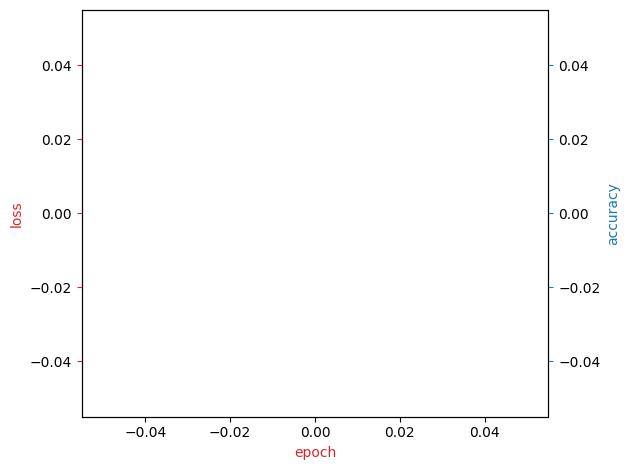

In [20]:
def plot(COST,ACC):
    fig, ax1 = plt.subplots()
    color = 'tab:red'
    ax1.plot(COST, color=color)
    ax1.set_xlabel('epoch', color=color)
    ax1.set_ylabel('loss', color=color)
    ax1.tick_params(axis='y', color=color)

    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('accuracy', color=color)  # you already handled the x-label with ax1
    ax2.plot(ACC, color=color)
    ax2.tick_params(axis='y', color=color)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped

    plt.show()

plot(cum_loss_list, acc_epoch)

# 2a) GPT-like Decoder: <span style="background-color: yellow"> Generative AI</span> for text generation

## IMDB Dataset and tokenizer

When training language models, it is generally advisable to use general-domain text. However, in this case, we are using the IMDB dataset, which is well-suited for classification tasks. Also, we use IMDB due to its smaller size and compatibility with machines that have limited RAM.

In [21]:
#running time: 1m 36s

from torchtext.datasets import IMDB # sentiment analysis dataset with (label, text) pairs

train_iter, val_iter = IMDB()
train_dataset = to_map_style_dataset(train_iter)
val_dataset = to_map_style_dataset(val_iter)

print(len(train_dataset), len(val_dataset))

UNK_IDX, PAD_IDX, EOS_IDX = 0, 1, 2
special_symbols = ['<unk>', '<pad>', '<|endoftext|>']

tokenizer = get_tokenizer("basic_english")

def yield_tokens(data_iter):

    for _,data_sample in data_iter:
        yield  tokenizer(data_sample)

vocab = build_vocab_from_iterator(yield_tokens(train_iter), specials = special_symbols, special_first = True)
vocab.set_default_index(UNK_IDX)

25000 12500


Examples:

In [22]:
train_iter, val_iter = IMDB()
iterator = iter(train_iter)

print(next(iterator))

print(next(iterator))

(1, 'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far between

The following function gives a string of token (importantly with the white spaces), given a list of indices as input:

In [23]:
def index_to_en(ids_list):
    string=''
    for idx in ids_list:
        token = vocab.get_itos()[idx]
        string = string + ' ' +token
    return string.strip()

# index_to_en = lambda seq_en: " ".join([vocab.get_itos()[index] for index in seq_en]) # done by IBM

index_to_en([0,1,2,3,4,5,6])

'<unk> <pad> <|endoftext|> the . , and'

## Creating the src and tgt sentences

To train a regressive model, we want to predict the next word. To this end, given a text, we want to take a sentence and then to take the same sentence but shifted of one position. For example, we want to create:

```
src:  ['around', 'a', 'young', 'swedish', 'drama', 'student', 'named', 'lena', 'who', 'wants']
tgt:  ['a', 'young', 'swedish', 'drama', 'student', 'named', 'lena', 'who', 'wants', 'to']
```

so that we give to the model $x_0$ 'around', and it predicts the logits $z_1$ which must be confronted with 'a ' = $x_1 \in \text{tgt}$. <span style="background-color: yellow">Really</span>, $x_i$ are the indices associated to the tokens:

In [24]:
def get_sample(block_size, tokenized_text): # the src_ and tgt_sequence will be of block_size lenght
                                 
    tokenized_text_length = len(tokenized_text)
    random_sample_stop = tokenized_text_length - block_size

    # Check if a random sample can be taken (if the text is longer than block_size)
    if random_sample_stop >= 1:
        # Randomly select a starting point for the sample
        random_start = torch.randint(low=0, high = random_sample_stop, size=(1,)).item()
        # Define the endpoint of the sample
        stop = random_start + block_size

        # Create the input and target sequences
        src_sequence = tokenized_text[random_start:stop]
        tgt_sequence= tokenized_text[random_start + 1:stop + 1]

    # Handle the case where the text length is exactly equal or less the block size
    elif random_sample_stop <= 0:
        # Start from the beginning and use the entire text
        random_start = 0
        stop = tokenized_text_length
        src_sequence= tokenized_text[random_start:stop]
        tgt_sequence = tokenized_text[random_start + 1:stop]
        # Append an empty string to maintain sequence alignment
        tgt_sequence.append( '<|endoftext|>')

    return vocab(src_sequence), vocab(tgt_sequence)

example of usage:

In [25]:
sentiment, text = next(iterator)
text = tokenizer(text)
block_size=30
src_sequences, tgt_sequence=get_sample(block_size, text)

print("src: ",src_sequences)
print("tgt: ",tgt_sequence)

src:  [36, 239, 244, 15369, 20, 1236, 4504, 12, 93, 12, 2385, 29, 45, 117, 679, 1305, 23, 12, 131, 45, 212, 108, 35669, 6217, 4, 3, 497, 270, 250, 21]
tgt:  [239, 244, 15369, 20, 1236, 4504, 12, 93, 12, 2385, 29, 45, 117, 679, 1305, 23, 12, 131, 45, 212, 108, 35669, 6217, 4, 3, 497, 270, 250, 21, 66]


## Collate function and Loader

In [26]:
BLOCK_SIZE = 30

UNK_IDX, PAD_IDX, EOS_IDX = 0, 1, 2

def collate_batch(batch):
    src_batch, tgt_batch = [], [] #the sum of lists
    for sentiment, text in batch:

      src_sequence, tgt_sequence = get_sample(BLOCK_SIZE, tokenizer(text)) #src_sequence, tgt_sequence are list of indices

      src_sequence = torch.tensor(src_sequence, dtype = torch.int64)
      tgt_sequence = torch.tensor(tgt_sequence, dtype = torch.int64)

      src_batch.append(src_sequence)
      tgt_batch.append(tgt_sequence)

    src_batch = pad_sequence(src_batch, padding_value = PAD_IDX, batch_first = False)
    tgt_batch = pad_sequence(tgt_batch, padding_value = PAD_IDX, batch_first = False)

    return src_batch.to(device), tgt_batch.to(device)

BATCH_SIZE = 2

train_iter, val_iter = IMDB()

train_dataloader = DataLoader(train_iter, batch_size = BATCH_SIZE, shuffle = True, collate_fn = collate_batch)
# an element of train_loader has shape torch.Size([BLOCK_SIZE, BATCH_SIZE])

val_dataloader= DataLoader(val_iter , batch_size = BATCH_SIZE, shuffle = False, collate_fn = collate_batch)

## Causal Masking

The explanation of the following code is in the Training-Decoder section.

In [27]:
def generate_square_subsequent_mask(size, device = device):
    mask = (torch.triu(torch.ones((size, size), device = device)) == 1).transpose(0, 1).float() #
    mask = mask.masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

print(generate_square_subsequent_mask(3))

tensor([[0., -inf, -inf],
        [0., 0., -inf],
        [0., 0., 0.]])


Next, given a sequence coming from a loader (which has dimension ([BLOCK_SIZE, BATCH_SIZE])), we want to apply the mask to it. Thus we create a src_mask with dimension BLOCK_SIZE x BLOCK_SIZE (that will be passed directly in the model nn.TrasformerDecoderLayer, without adding manually this to the input) and also a src_padding_mask, because our sentences are padded to the right, and the padding must not influence the attention mechanism. For this reason, we will pass to the nn.TrasformerDecoderLayer src_padding_mask:

In [28]:
def create_masks(src, device = device):
    src_seq_len = src.shape[0] # =BLOCK_SIZE

    src_mask = generate_square_subsequent_mask(src_seq_len, device)

    src_padding_mask = (src == PAD_IDX).transpose(0, 1) #filled with True and False

    return src_mask , src_padding_mask

#usage example
src, tgt = next(iter(train_dataloader))
src_mask, src_padding_mask = create_masks(src)
print(src_mask.shape)

src_padding_mask


torch.Size([30, 30])


tensor([[False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False]])

## Positional encoding

Second version of the positional encoding (because we used `batch_first = False`) in the `collate_batch`:

In [29]:
class PositionalEncoding(nn.Module):
    def __init__(self, embed_dim: int, max_len: int = 5000, dropout: float = 0.1):
        super().__init__()

        pos = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        term = torch.exp(
            torch.arange(0, embed_dim, 2).float() * (-math.log(10000.0) / embed_dim)
        )

  
        pe = torch.zeros(max_len, embed_dim)
        pe[:, 0::2] = torch.sin(pos * term) 
        pe[:, 1::2] = torch.cos(pos * term)  

        pe = pe.unsqueeze(1)  # shape: [max_len, 1, embed_dim]

        self.register_buffer("pe", pe)  # tensor non learnable salvato nel modello
        self.dropout = nn.Dropout(p = dropout)  # dropout per regolarizzazione

    def forward(self, x: Tensor): # expected x: [seq_len, batch_size, embed_dim]
        
        x = x + self.pe[:x.size(0), :, :]
        return self.dropout(x)

## My GPT model

If confused by the presence of encoder layers, give a look to **SOURCE OF CONFUSION on GPT** in C). Look at the model from the previous 'encoder for AG classification': they are very similar, except from the final layer, which has the vocab size (here).

In [30]:
class CustomGPTModel(nn.Module):
    def __init__(self, embed_size, vocab_size, num_heads, num_of_decoder_blocks, max_seq_len = 5000, dropout = 0.1):
        super().__init__()
        
        self.embed_size = embed_size

        #input layer for embedding and sum with positional encoding
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.positional_encoding = PositionalEncoding(embed_size, dropout = dropout)

        # Remaining layers are part of the TransformerDecoder
        encoder_layers = nn.TransformerEncoderLayer(d_model = embed_size, nhead = num_heads, dropout = dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers = num_of_decoder_blocks)

        # output layer for prediction
        self.lm_head = nn.Linear(embed_size, vocab_size)

        self.init_weights()

    def init_weights(self):
      for p in self.parameters():
          if p.dim() > 1:
              nn.init.xavier_uniform_(p)


    def forward(self, x, src_mask = None, src_padding_mask = None):

        if src_mask is None and src_padding_mask is None:

            src_mask, src_padding_mask = create_masks(x)

        seq_length = x.size(0)

        # Add positional embeddings to the input embeddings
        x = self.embed(x)* math.sqrt(self.embed_size) #src = self.embedding(src) * math.sqrt(self.d_model)
        x = self.positional_encoding(x)

        output = self.transformer_encoder(x, mask = src_mask, src_key_padding_mask = src_padding_mask)
        logits = self.lm_head(output)

        return logits

In [31]:
ntokens = len(vocab)  # size of vocabulary
emsize = 200  # embedding dimension
num_of_decoder_blocks = 2  # number of ``nn.TransformerEncoderLayer`` in ``nn.TransformerEncoder``
nhead = 2  # number of heads in ``nn.MultiheadAttention``
dropout = 0.2  # dropout probability

model = CustomGPTModel(embed_size = emsize, num_heads = nhead,
                        num_of_decoder_blocks = num_of_decoder_blocks, vocab_size = ntokens,
                        dropout = dropout).to(device)

/opt/miniconda3/envs/Trans_env/lib/python3.10/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


## (proof of) Text generation 

The text generation needs a starting point, which is called prompt. This prompt should be tokenized, should not be None and should not be too long:

In [32]:
def indicized_prompt(prompt, block_size = BLOCK_SIZE):
    # Handle None prompt
    while prompt is None:
        prompt = input("Sorry, prompt cannot be empty. Please enter a valid prompt: ")

    tokens = tokenizer(prompt)
    number_of_tokens = len(tokens)

    # Handle long prompts
    if number_of_tokens > block_size:
        tokens = tokens[-block_size:]  # Keep last block_size characters

    prompt_indices = vocab(tokens)

    prompt_encoded = torch.tensor(prompt_indices, dtype=torch.int64).reshape(-1, 1)
    return prompt_encoded

Usage example:

In [33]:
model.eval() #to deactivate dropout
prompt_encoded = indicized_prompt("This is a prompt to get model generate next words.").to(device) #11 tokens
logits = model(prompt_encoded, src_mask = None).to(device)
logits.shape #torch.Size([11, 1, 100685])
logits = logits.transpose(0, 1) #torch.Size([1, 11, 100685])
logits.shape
logit_preiction =logits[:,-1]
_, next_word_index = torch.max(logit_preiction, dim=1)
next_word_index

index_to_en(next_word_index)

/opt/miniconda3/envs/Trans_env/lib/python3.10/site-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched src_key_padding_mask and mask is deprecated. Use same type for both instead.
  warnings.warn(


'gave'

Then we can define a function that, given the indicized_prompt, do generation

In [34]:
def generate(model, prompt=None, max_new_tokens = 500, block_size = BLOCK_SIZE, vocab = vocab, tokenizer = tokenizer):
    model.eval()
    model.to(device)
    prompt_encoded = indicized_prompt(prompt).to(device)
    tokens = []

    # Generate new tokens up to max_new_tokens
    for _ in range(max_new_tokens):
        # Decode the encoded prompt using the model's decoder
        logits = model(prompt_encoded,src_mask=None,src_padding_mask=None)

        # Transpose the logits to bring the sequence length to the first dimension
        logits = logits.transpose(0, 1)

        # Select the logits of the last token in the sequence
        logit_prediction = logits[:, -1]

        # Choose the most probable next token from the logits(greedy decoding)
        next_token_encoded = torch.argmax(logit_prediction, dim=-1).reshape(-1, 1)

        # If the next token is the end-of-sequence (EOS) token, stop generation
        if next_token_encoded.item() == EOS_IDX:
            break

        # Append the next token to the prompt_encoded and keep only the last 'block_size' tokens
        prompt_encoded = torch.cat((prompt_encoded, next_token_encoded), dim=0)[-block_size:]

        # Convert the next token index to a token string using the vocabulary
        # Move the tensor back to CPU for vocab lookup if needed
        token_id = next_token_encoded.to('cpu').item()
        tokens.append(vocab.get_itos()[token_id])

    # Join the generated tokens into a single string and return
    return ' '.join(tokens)

The generation, of course, is awful because we did not train the model:

In [35]:
generate(model,prompt="this is the beginning of",max_new_tokens = 30,vocab = vocab,tokenizer = tokenizer)

'gave gave gave gave gave gave gave eschelons eschelons eschelons computing computing computing computing eschelons eschelons eschelons captioned computing wave wave eschelons eschelons dive-bombing dive-bombing zang noodle zang noodle zang'

## Accuracy

In [36]:
loss_fn = CrossEntropyLoss(ignore_index=PAD_IDX)

def evaluate(model: nn.Module, eval_data) -> float:
    model.eval()  # turn on evaluation mode
    total_loss = 0.
    with torch.no_grad():
        for src,tgt in eval_data:
            tgt = tgt.to(device)
            #seq_len = src.size(0)
            logits = model(src)
            total_loss +=  loss_fn(logits.reshape(-1, logits.shape[-1]), tgt.reshape(-1)).item()
    return total_loss / (len(list(eval_data)) - 1)

In [37]:
#evaluate(model,val_dataloader)

## Training

In [38]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=0.01, betas=(0.9, 0.999))
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 10000, gamma=0.9)

def train(model: nn.Module,train_data) -> None:
    model.train()  # turn on train mode
    total_loss = 0.
    log_interval = 10000
    start_time = time.time()

    num_batches = len(list(train_data)) //BLOCK_SIZE
    for batch,srctgt in enumerate(tqdm(train_data)):
        src= srctgt[0]
        tgt= srctgt[1]
        logits = model(src,src_mask=None)
        logits_flat = logits.reshape(-1, logits.shape[-1])
        loss = loss_fn(logits_flat, tgt.reshape(-1))

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()
        total_loss += loss.item()

        if (batch % log_interval == 0 and batch > 0) or batch==42060:
            lr = scheduler.get_last_lr()[0]
            ms_per_batch = (time.time() - start_time) * 1000 / log_interval
            #cur_loss = total_loss / log_interval
            cur_loss = total_loss / batch
            ppl = math.exp(cur_loss)
            print(f'| epoch {epoch:3d} | {batch//BLOCK_SIZE:5d}/{num_batches:5d} batches | '
                  f'lr {lr:02.4f} | ms/batch {ms_per_batch:5.2f} | '
                  f'loss {cur_loss:5.2f} | ppl {ppl:8.2f}')
            start_time = time.time()

    return total_loss

It works, but it is commented for time saving

In [39]:
best_val_loss = float('inf')
epochs = 1
Train_losses= []
Val_losses = []
# for epoch in range(1, epochs + 1):
#     epoch_start_time = time.time()
#     train_loss = train(model,train_dataloader)
#     val_loss = evaluate(model, val_dataloader)
#     val_ppl = math.exp(val_loss)
#     Train_losses.append(train_loss)
#     Val_losses.append(val_loss)

#     elapsed = time.time() - epoch_start_time
#     print('-' * 89)
#     print(f'| end of epoch {epoch:3d} | time: {elapsed:5.2f}s | '
#         f'valid loss {val_loss:5.2f} | valid ppl {val_ppl:8.2f}')
#     print('-' * 89)

#     if val_loss < best_val_loss:
#         best_val_loss = val_loss
#         torch.save(model.state_dict(), 'model_best_val_loss.pt')

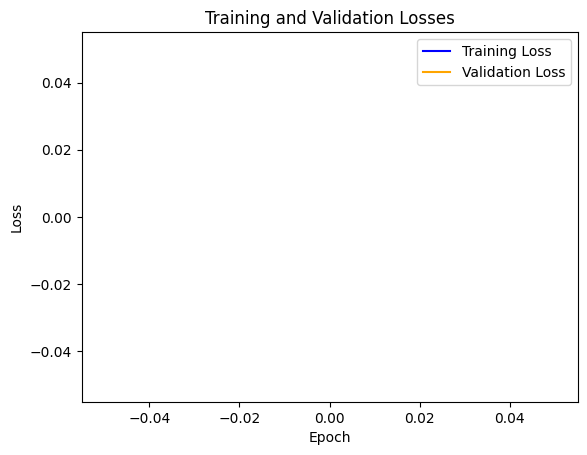

In [40]:
# Calculate the number of epochs (assuming the lengths of train_losses and val_losses are equal)
num_epochs = len(Train_losses)

# Create a figure and a set of subplots
fig, ax = plt.subplots()

# Plot the training losses
ax.plot(range(num_epochs), Train_losses, label='Training Loss', color='blue')

# Plot the validation losses
ax.plot(range(num_epochs), Val_losses, label='Validation Loss', color='orange')

# Set the x-axis label
ax.set_xlabel('Epoch')

# Set the y-axis label
ax.set_ylabel('Loss')

# Set the title of the plot
ax.set_title('Training and Validation Losses')

# Add a legend to the plot
ax.legend()

# Show the plot
plt.show()

# 2b) MLM+NSP pre-training of a BERT-like Encoder, with PyTorch

Here we do the pre-training from scratch. Later, we will do the same but we take a model from HuggingFace.

## IMDB Dataset

We start with the usual things, as in 2a), but with more special symbols:

In [41]:
from torchtext.datasets import IMDB

train_iter, test_iter = IMDB(split=('train', 'test'))
all_data_iter = chain(train_iter, test_iter)

PAD_IDX, CLS_IDX, SEP_IDX,  MASK_IDX, UNK_IDX = 0, 1, 2, 3, 4
special_symbols = ['[PAD]','[CLS]', '[SEP]','[MASK]','[UNK]']

tokenizer = get_tokenizer("basic_english")

def yield_tokens(data_iter):

    for label, data_sample in data_iter:
        yield  tokenizer(data_sample)

vocab = build_vocab_from_iterator(yield_tokens(all_data_iter), specials = special_symbols, special_first = True) #build vocab from all data
vocab.set_default_index(UNK_IDX)

VOCAB_SIZE = len(vocab)
print('Size of vocabulary:', VOCAB_SIZE)

Size of vocabulary: 125092


In [42]:
def index_to_en(ids_list): #index_to_english
    string=''
    for idx in ids_list:
        token = vocab.get_itos()[idx]
        string = string + ' ' +token
    return string.strip()

all_data_iter = chain(train_iter, test_iter)

fifth_item_tokens = next(islice(yield_tokens(all_data_iter), 5, None))
print(fifth_item_tokens[:20])

['i', 'would', 'put', 'this', 'at', 'the', 'top', 'of', 'my', 'list', 'of', 'films', 'in', 'the', 'category', 'of', 'unwatchable', 'trash', '!', 'there']


Then we want to prepare data for MLM and NSP. We define a MLM and a NSP function, which at the end will be unified. Notice that MLM is used also in NSP.

## MLM (Masked Language Modelling)

First we should have a method to compute random numbers. The `bernoulli_true_false` below does the game, but it is too complicated for a simple task. Moreover, as also `random.random()` from Python, is not compatible with GPU and it does not enter in the backprop scheme of PyTorch. For these reason, it is preferable to use `torch.rand()` or `torch.bernoulli()` from PyTorch. Attention!! Not use `torch.randn()`, which even if similar in the name, generates a normal distribution and not a probability.

In [43]:
# bernoulli_true_false by IBM, we will not use it

def bernoulli_true_false(probability):
    # Create a Bernoulli distribution with probability p
    bernoulli_dist = torch.distributions.Bernoulli(torch.tensor([probability]))
    # Sample from this distribution and convert 1 to True and 0 to False
    return bernoulli_dist.sample().item() == 1

bernoulli_true_false(0.7)

True

The following functions decide whether each token in a sequence should be masked, left unchanged, or replaced with a random token. This process is essential for training the model to predict masked words based on their context.

So we prepare a function for masking a single token, and then apply to a whole tokenized sequence in the subsequent function:

In [44]:
# Masking done by IBM, with bernoulli_true_false and weird probabilities

def Masking(token):
    
    mask = bernoulli_true_false(0.2) # Decide whether to mask this token (20% chance); this is True or False

    if mask is False: # If mask is False, return with '[PAD]' label
        token_ = token
        mask_label = '[PAD]'

    random_opp = bernoulli_true_false(0.5)
    random_swich = bernoulli_true_false(0.5)

    if mask is True and random_opp is True and random_swich is True: # Replace the token with '[MASK]' and set label to a random token
        token_ = '[MASK]'
        mask_label = index_to_en(torch.randint(0, VOCAB_SIZE, (1,)))
    
    elif mask is True and random_opp is True and random_swich is False: # Leave the token unchanged and set label to the same token
        token_ = token
        mask_label = token

    else: # Replace the token with '[MASK]' and set label to the original token
        token_ = '[MASK]'
        mask_label = token

    return token_, mask_label

In [45]:
# This respects the original BERT probabilities

def BERT_Masking(original_token): # it returns a couple of input_token, label_token
   
    if torch.rand(1).item() >= 0.15:  # Decide if this token should be masked (15% chance)
        input_token = original_token
        label_token = '[PAD]'
        return input_token, label_token

    rand = torch.rand(1).item() # Choose the masking strategy

    if rand < 0.8:  # 80% of the time → [MASK] in input, original token in label
        input_token = '[MASK]'
        label_token = original_token
        return input_token, label_token
    
    elif rand < 0.9: # 10% of the time → original token in input, original token in label
        input_token = original_token
        label_token = original_token
        return input_token, label_token
    
    else: # 10% of the time → random token in input, original token in label
        
        random_index = torch.randint(0, VOCAB_SIZE, (1,))
        random_token = index_to_en(random_index)
        input_token = random_token
        label_token = original_token
        return input_token, label_token

Apply the masking to a whole sequence:

In [46]:
def prepare_for_mlm(tokenized_sequence, include_raw_tokens = False):
    raw_tokens_list = []  # List to store raw tokens if needed
    bert_input = []  # List to store sentences processed for BERT's MLM
    bert_label = []  # List to store labels for each token (mask, random, or unchanged)
    current_raw_tokens = []
    current_bert_input = []
    current_bert_label = []

    for token in tokenized_sequence:
        masked_token, mask_label = BERT_Masking(token)

        current_bert_input.append(masked_token)
        current_bert_label.append(mask_label)

        if include_raw_tokens is True:
            current_raw_tokens.append(token)

        if token in ['.', '?', '!']: # Check if the token is a sentence delimiter (., ?, !)
            
            if len(current_bert_input) > 2: # If current sentence has more than two tokens, consider it a valid sentence
                bert_input.append(current_bert_input)
                bert_label.append(current_bert_label)
                
                if include_raw_tokens: # If including raw tokens, add the current list of raw tokens to the raw tokens list
                    raw_tokens_list.append(current_raw_tokens)

                # Reset the lists for the next sentence
                current_bert_input = []
                current_bert_label = []
                current_raw_tokens = []

            else: # If the current sentence is too short, discard it and reset lists
                current_bert_input = []
                current_bert_label = []
                current_raw_tokens = []

    if current_bert_input: # Add any remaining tokens as a sentence if there are any
        bert_input.append(current_bert_input)
        bert_label.append(current_bert_label)
        if include_raw_tokens:
            raw_tokens_list.append(current_raw_tokens)

    # Return the prepared lists for BERT's MLM training
    return (bert_input, bert_label, raw_tokens_list) if include_raw_tokens else (bert_input, bert_label)

Usage example:

In [47]:
original_input = "The sun sets behind the distant mountains"
tokenized_sequence = tokenizer(original_input)

bert_input, bert_label, raw_tokens_list = prepare_for_mlm(tokenized_sequence, include_raw_tokens = True)

print('raw:',raw_tokens_list)
print('bert_input is:',bert_input)
print('bert_label is:',bert_label)

raw: [['the', 'sun', 'sets', 'behind', 'the', 'distant', 'mountains']]
bert_input is: [['[MASK]', 'sun', 'sets', 'behind', 'the', 'distant', 'mountains']]
bert_label is: [['the', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']]


## NSP (Next Sequence Predictions) + MLM

The following is an intermediate step. At the moment, for each sentence we have prepared the masked sentence and the masked label using the `prepare_for_mlm` function. Then, given a list of sentences, we want to create the mlm things and thn split both in the nsp sense (that is, add the nsp label 0/1 to sentence B and also add < CLS > and < PAD >).

The input of the following function should be the couple (input_mlm_sentences, input_mlm_labels), obtained from `prepare_for_mlm`.

In [48]:
def process_for_nsp(input_mlm_sentences, input_mlm_labels): # input_mlm_sentences = list of tokenized sentences
                                                           # input_mlm_labels = corresponding label masked list 
                                                           #                       will be the result of prepare_for_mlm function
    if len(input_mlm_sentences) < 2:
       raise ValueError("Must have at least two sentences.")

    # Verify that both input lists are of the same length and have a sufficient number of sentences
    if len(input_mlm_sentences) != len(input_mlm_labels):
        raise ValueError("Both lists must have the same number of items.")

    bert_input = []
    mlm_label = []
    nsp_label = []
    available_indices = list(range(len(input_mlm_sentences)))

    while len(available_indices) >= 2:
        if random.random() < 0.5:
            # Choose two consecutive sentences to simulate the 'next sentence' scenario
            index = random.choice(available_indices[:-1])  # Exclude the last index
            # append list and add  '[CLS]' and  '[SEP]' tokens
            bert_input.append([['[CLS]']+input_mlm_sentences[index]+ ['[SEP]'],input_mlm_sentences[index + 1]+ ['[SEP]']])
            mlm_label.append([['[PAD]']+input_mlm_labels[index]+['[PAD]'], input_mlm_labels[index + 1]+ ['[PAD]']])
            nsp_label.append(1)  # Label 1 indicates these sentences are consecutive

            # Remove the used indices
            available_indices.remove(index)
            if index + 1 in available_indices:
                available_indices.remove(index + 1)
        else:
            # Choose two random distinct sentences to simulate the 'not next sentence' scenario
            indices = random.sample(available_indices, 2)
            bert_input.append([['[CLS]']+input_mlm_sentences[indices[0]]+['[SEP]'],input_mlm_sentences[indices[1]]+ ['[SEP]']])
            mlm_label.append([['[PAD]']+input_mlm_labels[indices[0]]+['[PAD]'], input_mlm_labels[indices[1]]+['[PAD]']])
            nsp_label.append(0)  # Label 0 indicates these sentences are not consecutive

            # Remove the used indices
            available_indices.remove(indices[0])
            available_indices.remove(indices[1])
            
    return bert_input, mlm_label, nsp_label

Usage example:

In [49]:
original_sentences = [["i", "love", "apples"], ["she", "enjoys", "reading", "books"], ["he", "likes", "playing", "guitar", "a","lot"]]

input_mlm_sentences = []     # contains masked input
input_mlm_labels = []           # contains corresponding MLM labels

for sentence in original_sentences:
    masked, labels = prepare_for_mlm(sentence)
    input_mlm_sentences.append(masked)
    input_mlm_labels.append(labels)

bert_input, mlm_label, nsp_label = process_for_nsp(input_mlm_sentences, input_mlm_labels)

print("BERT Input:")
for pair in bert_input:
    print(pair)
print("MLM Label:")
for pair in mlm_label:
    print(pair)
print("NSP Label (is next): ", nsp_label)


BERT Input:
[['[CLS]', ['i', 'love', 'apples'], '[SEP]'], [['she', 'enjoys', 'reading', 'books'], '[SEP]']]
MLM Label:
[['[PAD]', ['[PAD]', '[PAD]', '[PAD]'], '[PAD]'], [['[PAD]', '[PAD]', '[PAD]', '[PAD]'], '[PAD]']]
NSP Label (is next):  [1]


What is still missing? It is missing the padding, the segmentation ( segment id 0 to segment A and 1 to segment B) and the conversion in indices using vocabulary for being used by BERT.

The following function takes as input the ouput of the `process_for_nsp`.

In [50]:
def prepare_bert_final_inputs(bert_input, mlm_label, nsp_label, to_tensor=True):
    """
    Prepara input_ids, mlm_labels, segment_ids, nsp_labels per l'input a BERT.
    """

    def zero_pad_list_pair(pair_, pad='[PAD]'):
        pair = deepcopy(pair_)
        max_len = max(len(pair[0]), len(pair[1]))
        pair[0].extend([pad] * (max_len - len(pair[0])))
        pair[1].extend([pad] * (max_len - len(pair[1])))
        return pair

    def flatten(l):
        return [item for sublist in l for item in sublist]

    def tokens_to_index(tokens):
        return [vocab[token] if isinstance(token, str) else vocab[str(token)] for token in tokens]

    input_ids_final = []
    mlm_labels_final = []
    segment_ids_final = []
    nsp_labels_final = []

    for input_pair, label_pair, is_next in zip(bert_input, mlm_label, nsp_label):
        # Segment IDs: 0 per frase A, 1 per frase B
        segment_ids = [[0] * len(input_pair[0]), [1] * len(input_pair[1])]

        # Padding
        input_padded = zero_pad_list_pair(input_pair)
        label_padded = zero_pad_list_pair(label_pair)
        segment_padded = zero_pad_list_pair(segment_ids, pad=0)

        # Flatten
        input_flat = flatten(input_padded)
        label_flat = flatten(label_padded)
        segment_flat = flatten(segment_padded)

        # Conversione e append
        if to_tensor:
            input_ids_final.append(torch.tensor(tokens_to_index(input_flat), dtype=torch.int64))
            mlm_labels_final.append(torch.tensor(tokens_to_index(label_flat), dtype=torch.int64))
            segment_ids_final.append(torch.tensor(segment_flat, dtype=torch.int64))
            nsp_labels_final.append(torch.tensor(is_next, dtype=torch.int64))
        else:
            input_ids_final.append(tokens_to_index(input_flat))
            mlm_labels_final.append(tokens_to_index(label_flat))
            segment_ids_final.append(segment_flat)
            nsp_labels_final.append(is_next)

    return input_ids_final, mlm_labels_final, segment_ids_final, nsp_labels_final


Usage example:

In [51]:
original_sentences = [["i", "love", "apples"], ["she", "enjoys", "reading", "books"], ["he", "likes", "playing", "guitar", "a","lot"]]

input_mlm_sentences = []     # contains masked input
input_mlm_labels = []           # contains corresponding MLM labels

for sentence in original_sentences:
    masked, labels = prepare_for_mlm(sentence)
    input_mlm_sentences.append(masked)
    input_mlm_labels.append(labels)

bert_input, mlm_label, nsp_label = process_for_nsp(input_mlm_sentences, input_mlm_labels)

bert_inputs_final, mlm_labels_final, segment_labels_final, nsp_labels_final = prepare_bert_final_inputs(bert_input, 
                                                                                                        mlm_label, 
                                                                                                        nsp_label, 
                                                                                                        to_tensor = True)



torch.set_printoptions(linewidth=10000)# this assures that whole output is printed in one line
print("input:\t\t",bert_input,"\ninputs_final:\t",bert_inputs_final,"\nbert labels final:\t",mlm_labels_final,"\nsegment labels final:\t",segment_labels_final,"\nis nexts final:\t",nsp_labels_final)

input:		 [[['[CLS]', ['i', 'love', 'apples'], '[SEP]'], [['[MASK]', 'enjoys', 'reading', 'books'], '[SEP]']]] 
inputs_final:	 [tensor([1, 4, 2, 4, 2, 0])] 
bert labels final:	 [tensor([0, 4, 0, 4, 0, 0])] 
segment labels final:	 [tensor([0, 0, 0, 1, 1, 0])] 
is nexts final:	 [tensor(1)]


## BERT Dataset creation

Then we create a csv final which contains all this. This will be the dataset for training the BERT model

This is commented because it is very very long. In the next section, we will load the already-done dataset.

In [52]:
# csv_file_path = 'train_bert_data_new.csv'

# with open(csv_file_path, mode='w', newline='', encoding='utf-8') as file:
#     csv_writer = csv.writer(file)
#     csv_writer.writerow(['Original Text', 'Input IDs', 'MLM Labels', 'Segment IDs', 'Is Next'])

#     # Wrap train_iter with tqdm for a progress bar
#     for n, (_, sample) in enumerate(tqdm(train_iter, desc="Processing samples")):
#         # Tokenize the sample input
#         tokens = tokenizer(sample)

#         # Create MLM inputs and labels
#         mlm_inputs, mlm_labels = prepare_for_mlm(tokens, include_raw_tokens=False)
#         if len(mlm_inputs) < 2:
#             continue  # Skip short samples

#         # Create NSP input pairs and labels
#         bert_input, mlm_label, nsp_label = process_for_nsp(mlm_inputs, mlm_labels)

#         # Add padding, create segment labels, and convert to indices/tensors
#         input_ids_final, mlm_labels_final, segment_ids_final, nsp_labels_final = prepare_bert_final_inputs(
#             bert_input, mlm_label, nsp_label, to_tensor=True
#         )

#         # Convert tensors to list, format as JSON strings, and write to CSV
#         for input_ids, mlm_ids, segment_ids, is_next in zip(
#             input_ids_final, mlm_labels_final, segment_ids_final, nsp_labels_final
#         ):
#             input_ids_str = json.dumps(input_ids.tolist())
#             mlm_labels_str = json.dumps(mlm_ids.tolist())
#             segment_ids_str = ','.join(map(str, segment_ids.tolist()))
#             is_next_label = is_next.item() if isinstance(is_next, torch.Tensor) else int(is_next)

#             csv_writer.writerow([sample, input_ids_str, mlm_labels_str, segment_ids_str, is_next_label])

## BERT Dataset loading and Dataset class

In [53]:
# 1m28s

!wget -O BERT_dataset.zip https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/bZaoQD52DcMpE7-kxwAG8A.zip
!unzip -o BERT_dataset.zip

--2025-08-03 16:18:08--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/bZaoQD52DcMpE7-kxwAG8A.zip
Risoluzione di cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 169.45.118.108
Connessione a cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|169.45.118.108|:443... connesso.
Richiesta HTTP inviata, in attesa di risposta... 200 OK
Lunghezza: 88958506 (85M) [application/zip]
Salvataggio in: «BERT_dataset.zip»

BERT_dataset.zip    100%[===================>]  84.84M   638KB/s    in 80s     

2025-08-03 16:19:30 (1.06 MB/s) - «BERT_dataset.zip» salvato [88958506/88958506]

Archive:  BERT_dataset.zip
   creating: /Users/alex/Desktop/programmazione/notebooks/My notebooks/IBM Generative AI with LLMs/bert_dataset
  inflating: bert_dataset/.DS_Store  
  inflating: bert_dataset/bert_train_data.csv  
  inflating: bert_dataset/bert_test_d

In [54]:
class BERTCSVDataset(Dataset):
    def __init__(self, filename):
        self.data = pd.read_csv(filename)
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        try:
            # Carica i dati dal CSV con nomi coerenti con la scrittura
            input_ids = torch.tensor(json.loads(row['Input IDs']), dtype=torch.long)
            mlm_labels = torch.tensor(json.loads(row['MLM Labels']), dtype=torch.long)
            segment_ids = torch.tensor([int(x) for x in row['Segment IDs'].split(',')], dtype=torch.long)
            is_next = torch.tensor(row['Is Next'], dtype=torch.long)
            nsp_label = is_next
            original_text = row['Original Text']

        except json.JSONDecodeError as e:
            print(f"Error decoding JSON for row {idx}: {e}")
            print("Input IDs:", row['Input IDs'])
            print("MLM Labels:", row['MLM Labels'])
            return None  # Skips this sample

        # Tokenizzazione del testo originale (opzionale)
        encoded_input = self.tokenizer.encode_plus(
            original_text,
            add_special_tokens=True,
            max_length=512,
            padding='max_length',
            truncation=True,
            return_tensors="pt"
        )

        original_input_ids = encoded_input['input_ids'].squeeze()
        attention_mask = encoded_input['attention_mask'].squeeze()

        return (
            input_ids,          # Input tokens (with [CLS], [SEP], etc.)
            mlm_labels,         # MLM target labels
            segment_ids,        # Segment IDs (0/1)
            nsp_label,            # NSP label
            original_input_ids, # Optional: tokenized original sentence
            attention_mask,     # Optional: attention mask for original input
            original_text       # Raw input text
        )


## Collate function and DataLoader

In [55]:
PAD_IDX = 0
def collate_batch(batch):

   
    bert_inputs_batch, bert_labels_batch, segment_labels_batch, is_nexts_batch,input_ids_batch,attention_mask_batch,original_text_battch = [], [], [], [],[],[],[]

    for bert_input, bert_label, segment_label, is_next,input_ids,attention_mask,original_text in batch:
        # Convert each sequence to a tensor and append to the respective list
        bert_inputs_batch.append(torch.tensor(bert_input, dtype=torch.long))
        bert_labels_batch.append(torch.tensor(bert_label, dtype=torch.long))
        segment_labels_batch.append(torch.tensor(segment_label, dtype=torch.long))
        is_nexts_batch.append(is_next)
        input_ids_batch.append(input_ids)
        attention_mask_batch.append(attention_mask)
        original_text_battch.append(original_text)

    # Pad the sequences in the batch
    bert_inputs_final = pad_sequence(bert_inputs_batch, padding_value=PAD_IDX, batch_first=False)
    bert_labels_final = pad_sequence(bert_labels_batch, padding_value=PAD_IDX, batch_first=False)
    segment_labels_final = pad_sequence(segment_labels_batch, padding_value=PAD_IDX, batch_first=False)
    is_nexts_batch = torch.tensor(is_nexts_batch, dtype=torch.long)

    return bert_inputs_final, bert_labels_final, segment_labels_final, is_nexts_batch

BATCH_SIZE = 2

train_dataset_path = './bert_dataset/bert_train_data.csv'
test_dataset_path = './bert_dataset/bert_test_data.csv'

train_dataset = BERTCSVDataset(train_dataset_path)
test_dataset = BERTCSVDataset(test_dataset_path)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch)

/opt/miniconda3/envs/Trans_env/lib/python3.10/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


## The model

In [56]:
EMBEDDING_DIM = 10

class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size, emb_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size

    def forward(self, tokens: Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)

# Define the PositionalEncoding class as a PyTorch module for adding positional information to token embeddings
class PositionalEncoding(nn.Module):
    def __init__(self, emb_size: int, dropout: float, maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()
        # Create a positional encoding matrix as per the Transformer paper's formula
        den = torch.exp(- torch.arange(0, emb_size, 2) * math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding: torch.Tensor):
        # Apply the positional encodings to the input token embeddings

        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])

In [57]:
class BERTEmbedding (nn.Module):

    def __init__(self, vocab_size, emb_size ,dropout=0.1,train=True):

        super().__init__()

        self.token_embedding = TokenEmbedding( vocab_size,emb_size )
        self.positional_encoding = PositionalEncoding(emb_size,dropout)
        self.segment_embedding = nn.Embedding(3, emb_size)
        self.dropout = torch.nn.Dropout(p=dropout)

    def forward(self, bert_inputs, segment_labels=False):
        my_embeddings=self.token_embedding(bert_inputs)
        if self.training:
          x = self.dropout(my_embeddings + self.positional_encoding(my_embeddings) + self.segment_embedding(segment_labels))
        else:
          x = my_embeddings + self.positional_encoding(my_embeddings)

        return x

In [58]:
class BERT(torch.nn.Module):
    
    def __init__(self, vocab_size, d_model=768, n_layers=12, heads=12, dropout=0.1):
        """
        vocab_size: The size of the vocabulary.
        d_model: The size of the embeddings (hidden size).
        n_layers: The number of Transformer layers.
        heads: The number of attention heads in each Transformer layer.
        dropout: The dropout rate applied to embeddings and Transformer layers.
        """
        super().__init__()
        self.d_model = d_model
        self.n_layers = n_layers
        self.heads = heads

        # Embedding layer that combines token embeddings and segment embeddings
        self.bert_embedding = BERTEmbedding(vocab_size, d_model, dropout)

        # Transformer Encoder layers
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=heads, dropout=dropout,batch_first=False)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=n_layers)

        # Linear layer for Next Sentence Prediction
        self.nextsentenceprediction = nn.Linear(d_model, 2)

        # Linear layer for Masked Language Modeling
        self.masked_language = nn.Linear(d_model, vocab_size)

    def forward(self, bert_inputs, segment_labels):
        """
        bert_inputs: Input tokens.
        segment_labels: Segment IDs for distinguishing different segments in the input.
        mask: Attention mask to prevent attention to padding tokens.

        return: Predictions for next sentence task and masked language modeling task.
        """

        padding_mask = (bert_inputs == PAD_IDX).transpose(0, 1)
        # Generate embeddings from input tokens and segment labels
        my_bert_embedding = self.bert_embedding(bert_inputs, segment_labels)

        # Pass embeddings through the Transformer encoder
        transformer_encoder_output = self.transformer_encoder(my_bert_embedding,src_key_padding_mask=padding_mask)


        next_sentence_prediction = self.nextsentenceprediction(transformer_encoder_output[ 0,:])
        

        # Masked Language Modeling: Predict all tokens in the sequence
        masked_language = self.masked_language(transformer_encoder_output)

        return  next_sentence_prediction, masked_language

In [59]:
EMBEDDING_DIM = 10

# Define parameters
vocab_size = 147161  # Replace VOCAB_SIZE with your vocabulary size
d_model = EMBEDDING_DIM  # Replace EMBEDDING_DIM with your embedding dimension
n_layers = 2  # Number of Transformer layers
initial_heads = 12 # Initial number of attention heads
initial_heads = 2
# Ensure the number of heads is a factor of the embedding dimension
heads = initial_heads - d_model % initial_heads

dropout = 0.1  # Dropout rate

# Create an instance of the BERT model
model = BERT(vocab_size, d_model, n_layers, heads, dropout)

## Accuracy

In [60]:
PAD_IDX=0
loss_fn_mlm = nn.CrossEntropyLoss(ignore_index=PAD_IDX)# The loss function must ignore PAD tokens and only calculates loss for the masked tokens
loss_fn_nsp = nn.CrossEntropyLoss()

In [61]:
def evaluate(dataloader=test_dataloader, model=model, loss_fn_mlm=loss_fn_mlm, loss_fn_nsp=loss_fn_nsp, device=device):
    model.eval()  # Turn off dropout and other training-specific behaviors

    total_loss = 0
    total_next_sentence_loss = 0
    total_mask_loss = 0
    total_batches = 0
    with torch.no_grad():  # Turn off gradients for validation, saves memory and computations
        for batch in dataloader:
            bert_inputs, bert_labels, segment_labels, is_nexts = [b.to(device) for b in batch]

            # Forward pass
            next_sentence_prediction, masked_language = model(bert_inputs, segment_labels)

            # Calculate loss for next sentence prediction
            # Ensure is_nexts is of the correct shape for CrossEntropyLoss
            next_loss = loss_fn_nsp(next_sentence_prediction, is_nexts.view(-1))

            # Calculate loss for predicting masked tokens
            # Flatten both masked_language predictions and bert_labels to match CrossEntropyLoss input requirements
            mask_loss = loss_fn_mlm(masked_language.view(-1, masked_language.size(-1)), bert_labels.view(-1))

            # Sum up the two losses
            loss = next_loss + mask_loss
            if torch.isnan(loss):
                continue
            else:
                total_loss += loss.item()
                total_next_sentence_loss += next_loss.item()
                total_mask_loss += mask_loss.item()
                total_batches += 1

    avg_loss = total_loss / (total_batches + 1)
    avg_next_sentence_loss = total_next_sentence_loss / (total_batches + 1)
    avg_mask_loss = total_mask_loss / (total_batches + 1)

    print(f"Average Loss: {avg_loss:.4f}, Average Next Sentence Loss: {avg_next_sentence_loss:.4f}, Average Mask Loss: {avg_mask_loss:.4f}")
    return avg_loss

## Training

In [62]:
# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.01, betas=(0.9, 0.999))

# Training loop setup
num_epochs = 1
total_steps = num_epochs * len(train_dataloader)

# Define the number of warmup steps, e.g., 10% of total
warmup_steps = int(total_steps * 0.1)

# Create the learning rate scheduler
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=warmup_steps,
                                            num_training_steps=total_steps)

# Lists to store losses for plotting
train_losses = []
eval_losses = []

# for epoch in tqdm(range(num_epochs), desc="Training Epochs"):
#     model.train()
#     total_loss = 0

#     for step, batch in enumerate(tqdm(train_dataloader, desc=f"Epoch {epoch + 1}")):
#         bert_inputs, bert_labels, segment_labels, is_nexts = [b.to(device) for b in batch]

#         optimizer.zero_grad()
#         next_sentence_prediction, masked_language = model(bert_inputs, segment_labels)

#         next_loss = loss_fn_nsp(next_sentence_prediction, is_nexts)
#         mask_loss = loss_fn_mlm(masked_language.view(-1, masked_language.size(-1)), bert_labels.view(-1))

#         loss = next_loss + mask_loss
#         loss.backward()
#         torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
#         optimizer.step()
#         scheduler.step()  # Update the learning rate

#         total_loss += loss.item()

#         if torch.isnan(loss):
#             continue
#         else:
#             total_loss += loss.item()

#     avg_train_loss = total_loss / len(train_dataloader) + 1
#     train_losses.append(avg_train_loss)
#     print(f"Epoch {epoch+1} - Average training loss: {avg_train_loss:.4f}")

#     # Evaluation after each epoch
#     eval_loss = evaluate(test_dataloader, model, loss_fn_nsp, loss_fn_mlm, device)
#     eval_losses.append(eval_loss)

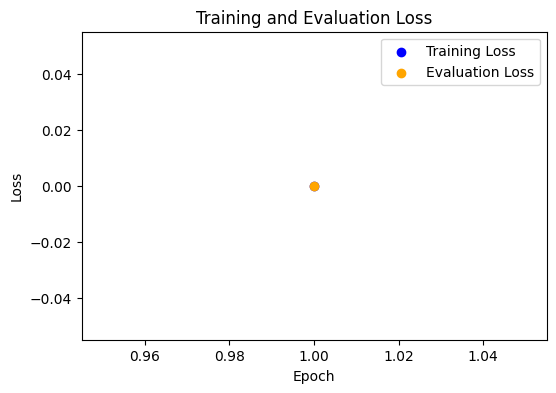

In [63]:
train_losses = [0]
eval_losses = [0]
# Plotting the loss values
plt.figure(figsize=(6, 4))
plt.scatter(range(1,num_epochs+1), train_losses, label="Training Loss", color='blue')
plt.scatter(range(1,num_epochs+1), eval_losses, label="Evaluation Loss", color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Evaluation Loss')
plt.legend()
plt.show()

## Inference

In [64]:
# Initialize the tokenizer with the BERT model's vocabulary
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model.eval()

def predict_nsp(sentence1, sentence2, model, tokenizer):
    # Tokenize sentences with special tokens
    tokens = tokenizer.encode_plus(sentence1, sentence2, return_tensors="pt")
    tokens_tensor = tokens["input_ids"].to(device)
    segment_tensor = tokens["token_type_ids"].to(device)

    # Predict
    with torch.no_grad():
        # Assuming the model returns NSP predictions first
        nsp_prediction, _ = model(tokens_tensor, segment_tensor)
        # Select the first element (first sequence) of the logits tensor
        first_logits = nsp_prediction[0].unsqueeze(0)  # Adds an extra dimension, making it [1, 2]
        logits = torch.softmax(first_logits, dim=1)
        prediction = torch.argmax(logits, dim=1).item()

    # Interpret the prediction
    return "Second sentence follows the first" if prediction == 1 else "Second sentence does not follow the first"

# Example usage
sentence1 = "The cat sat on the mat."
sentence2 = "It was a sunny day"

print(predict_nsp(sentence1, sentence2, model, tokenizer))

def predict_mlm(sentence, model, tokenizer):
    # Tokenize the input sentence and convert to token IDs, including special tokens
    inputs = tokenizer(sentence, return_tensors="pt")
    tokens_tensor = inputs.input_ids

    # Create dummy segment labels filled with zeros, assuming it's needed by your model
    segment_labels = torch.zeros_like(tokens_tensor)

    with torch.no_grad():
        # Forward pass through the model, now correctly handling the output tuple
        output_tuple = model(tokens_tensor, segment_labels)

        # Assuming the second element of the tuple contains the MLM logits
        predictions = output_tuple[1]  # Adjusted based on your model's output

        # Identify the position of the [MASK] token
        mask_token_index = (tokens_tensor == tokenizer.mask_token_id).nonzero(as_tuple=True)[1]

        # Get the predicted index for the [MASK] token from the MLM logits
        predicted_index = torch.argmax(predictions[0, mask_token_index.item(), :], dim=-1)
        predicted_token = tokenizer.convert_ids_to_tokens([predicted_index.item()])[0]

        # Replace [MASK] in the original sentence with the predicted token
        predicted_sentence = sentence.replace(tokenizer.mask_token, predicted_token, 1)

    return predicted_sentence


# Example usage
sentence = "The cat sat on the [MASK]."
print(predict_mlm(sentence, model, tokenizer))

Second sentence follows the first
The cat sat on the [UNK].


# 2c) Full Transformer from scratch

[link to the notebook](https://www.coursera.org/learn/generative-ai-language-modeling-with-transformers/ungradedLti/RI07m/lab-transformers-for-translation)

In [65]:
from torchtext.datasets import multi30k, Multi30k

# 3) Loading Models and Inference with Hugging Face

`tokenizer(text, return_tensors = "pt")` the 'pt' means PyTorch, but we can also use 'tf' fot TensorFlow!

## Without Pipeline

### Sentiment analysis with DistilBERT

First, let's initialize a tokenizer and a model for sentiment analysis using DistilBERT fine-tuned on the SST-2 dataset. This setup is useful for tasks where you need to quickly classify the sentiment of a piece of text with a pretrained, efficient transformer model.

In [66]:
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")

model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english").to("cpu")

labels = ["NEGATIVE", "POSITIVE"]

Usage example:

In [67]:
text = "Congratulations! You've won a free ticket to the Bahamas. Reply WIN to claim."

inputs = tokenizer(text, return_tensors = "pt") #dict {'input_ids': , 'attention_mask'}
print('inputs:',inputs,'\n') 

#inference part
with torch.no_grad():
    output_of_model = model(input_ids = inputs['input_ids'], 
                            attention_mask = inputs['attention_mask'])
print('output:',output_of_model,'\n')

#Post-process the output
logits_of_output = output_of_model.logits
print('output logits:',logits_of_output,'\n')

probs = torch.softmax(logits_of_output, dim = 1)
print('output probabilities:', probs,'\n')

predicted_class = torch.argmax(probs, dim = 1)
print('predicted class:', predicted_class,'which is', labels[predicted_class] )


inputs: {'input_ids': tensor([[  101, 23156,   999,  2017,  1005,  2310,  2180,  1037,  2489,  7281,  2000,  1996, 17094,  1012,  7514,  2663,  2000,  4366,  1012,   102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])} 

output: SequenceClassifierOutput(loss=None, logits=tensor([[-3.9954,  4.3336]]), hidden_states=None, attentions=None) 

output logits: tensor([[-3.9954,  4.3336]]) 

output probabilities: tensor([[2.4134e-04, 9.9976e-01]]) 

predicted class: tensor([1]) which is POSITIVE


### Text generation with GPT-2

In [68]:
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

model = GPT2LMHeadModel.from_pretrained("gpt2").to("cpu")

Usage example:

In [69]:
prompt = "Once upon a time"
inputs = tokenizer(prompt, return_tensors="pt")

output_ids = model.generate(
            input_ids = inputs['input_ids'], 
            attention_mask = inputs['attention_mask'],
            pad_token_id = tokenizer.eos_token_id,
            max_length = 50, 
            num_return_sequences = 1,
            temperature = 1,
            top_k = 50,
            top_p = 95,
            repetition_penalty = 1.2
)

print('outputs:',output_ids)

generated_text = tokenizer.decode(output_ids[0], skip_special_tokens = True)

print(generated_text)

/opt/miniconda3/envs/Trans_env/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:386: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


outputs: tensor([[ 7454,  2402,   257,   640,    11,   262,   995,   373,  5901,   351,   661,   508,   547,   407,   691,  5527,   475,   635,  3665,    13,   198,   464,   717,  1517,   326,  1625,   284,  2000,   618,   314,  1807,   286,   428,   318,   703,   881,  1637,   484,   550,   287,   511, 16511,   290,   644,  1611,   340,   561,   307,   611,  2130]])
Once upon a time, the world was filled with people who were not only rich but also powerful.
The first thing that came to mind when I thought of this is how much money they had in their pockets and what kind it would be if someone


### Filling Mask with bert-base-uncased

In [70]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
model = BertForMaskedLM.from_pretrained('bert-base-uncased')

text = "The [MASK] of France is Paris!"

mask_filler = pipeline(task = 'fill-mask',
                       model = model, 
                       tokenizer = tokenizer)

results = mask_filler(text)

for result in results:
    print(f"Predicted token: {result['token_str']}, Confidence: {result['score']:.2f}")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'bert.pooler.dense.bias', 'cls.seq_relationship.weight', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Predicted token: capital, Confidence: 0.86
Predicted token: heart, Confidence: 0.07
Predicted token: name, Confidence: 0.01
Predicted token: king, Confidence: 0.01
Predicted token: center, Confidence: 0.01


## How to use the Pipeline

 <span style="background-color: yellow"> **Pipeline code** </span>
```python
transformers.pipeline(
            task: str,
            model: Optional = None,
            config: Optional = None,
            tokenizer: Optional = None,
            feature_extractor: Optional = None,
            framework: Optional = None,
            revision: str = 'main',
            use_fast: bool = True,
            model_kwargs: Dict[str, Any] = None,
            **kwargs
)
```
 <span style="background-color: yellow"> **Parameters** </span>
- **task**: `str`
  - The task to perform, such as "text-classification", "text-generation", "question-answering", etc.
  - Example: `"text-classification"`

- **model**: `Optional`
  - The model to use. This can be a string (model identifier from Hugging Face model hub), a path to a directory containing model files, or a pre-loaded model instance.
  - Example: `"distilbert-base-uncased-finetuned-sst-2-english"`

- **config**: `Optional`
  - The configuration to use. This can be a string, a path to a directory, or a pre-loaded config object.
  - Example: `{"output_attentions": True}`

- **tokenizer**: `Optional`
  - The tokenizer to use. This can be a string, a path to a directory, or a pre-loaded tokenizer instance.
  - Example: `"bert-base-uncased"`

- **feature_extractor**: `Optional`
  - The feature extractor to use for tasks that require it (e.g., image processing).
  - Example: `"facebook/detectron2"`

- **framework**: `Optional`
  - The framework to use, either `"pt"` for PyTorch or `"tf"` for TensorFlow. If not specified, it will be inferred.
  - Example: `"pt"`

- **revision**: `str`, default `'main'`
  - The specific model version to use (branch, tag, or commit hash).
  - Example: `"v1.0"`

- **use_fast**: `bool`, default `True`
  - Whether to use the fast version of the tokenizer if available.
  - Example: `True`

- **model_kwargs**: `Dict[str, Any]`, default `None`
  - Additional keyword arguments passed to the model during initialization.
  - Example: `{"output_hidden_states": True}`

- **kwargs**: `Any`
  - Additional keyword arguments passed to the pipeline components.
<span style="background-color: yellow"> **Task types** </span>
The `pipeline()` function supports a wide range of NLP tasks. Here are some of the common tasks:

1. **Text Classification**: `text-classification`
   - **Purpose**: Classify text into predefined categories.
   - **Use Cases**: Sentiment analysis, spam detection, topic classification.

2. **Text Generation**: `text-generation`
   - **Purpose**: Generate coherent text based on a given prompt.
   - **Use Cases**: Creative writing, dialogue generation, story completion.

3. **Question Answering**: `question-answering`
   - **Purpose**: Answer questions based on a given context.
   - **Use Cases**: Building Q&A systems, information retrieval from documents.

4. **Named Entity Recognition (NER)**: `ner` (or `token-classification`)
   - **Purpose**: Identify and classify named entities (like people, organizations, locations) in text.
   - **Use Cases**: Extracting structured information from unstructured text.

5. **Summarization**: `summarization`
   - **Purpose**: Summarize long pieces of text into shorter, coherent summaries.
   - **Use Cases**: Document summarization, news summarization.

6. **Translation**: `translation_xx_to_yy` (e.g., `translation_en_to_fr`)
   - **Purpose**: Translate text from one language to another.
   - **Use Cases**: Language translation, multilingual applications.

7. **Fill-Mask**: `fill-mask`
   - **Purpose**: Predict masked words in a sentence (useful for masked language modeling).
   - **Use Cases**: Language modeling tasks, understanding model predictions.

8. **Zero-Shot Classification**: `zero-shot-classification`
   - **Purpose**: Classify text into categories without needing training data for those categories.
   - **Use Cases**: Flexible and adaptable classification tasks.

9. **Feature Extraction**: `feature-extraction`
   - **Purpose**: Extract hidden state features from text.
   - **Use Cases**: Downstream tasks requiring text representations, such as clustering, similarity, or further custom model training.

## With Pipeline

### Sentiment analysis with DistilBERT

In [71]:
classifier = pipeline(
    task = "text-classification",
    model = "distilbert-base-uncased-finetuned-sst-2-english",
    framework ="pt"
)

# Classify a sample text
result = classifier("Congratulations! You've won a free ticket to the Bahamas. Reply WIN to claim.")
print(result)

[{'label': 'POSITIVE', 'score': 0.9997586607933044}]


### Text generation with GPT-2

In [72]:
generator = pipeline(
    task = "text-generation", 
    model = "gpt2",
    framework ="pt"
)

prompt = "Once upon a time"
result = generator(prompt, 
                   max_length = 50,
                   num_return_sequences = 1)

# Print the generated text
print(result[0]['generated_text'])

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Once upon a time, a single child, or child-sized group of children, must be in their care during the daily process of caring for each other, or have at least one child who is not currently in or near their care and at least


### Filling mask with bert-base-uncased

In [73]:
fill_mask = pipeline(
    task = "fill-mask", 
    model = "bert-base-uncased",
    framework = "pt"
)

prompt = "The [MASK] of France is Paris!"
result = fill_mask(prompt)

# Print the generated text
for result in results:
    print(f"Predicted token: {result['token_str']}, Confidence: {result['score']:.2f}")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'bert.pooler.dense.bias', 'cls.seq_relationship.weight', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Predicted token: capital, Confidence: 0.86
Predicted token: heart, Confidence: 0.07
Predicted token: name, Confidence: 0.01
Predicted token: king, Confidence: 0.01
Predicted token: center, Confidence: 0.01


Same but with the tokenizer explicit

In [74]:
pretrained_model = BertForMaskedLM.from_pretrained('bert-base-uncased')
pretrained_tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

# Define the input text with a masked token
text = "The [MASK] of France is Paris!"

# Create the pipeline
mask_filler = pipeline(task='fill-mask', model=pretrained_model,tokenizer=pretrained_tokenizer)

# Perform inference using the pipeline
results = mask_filler(text)
for result in results:
    print(f"Predicted token: {result['token_str']}, Confidence: {result['score']:.2f}")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'bert.pooler.dense.bias', 'cls.seq_relationship.weight', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Predicted token: capital, Confidence: 0.86
Predicted token: heart, Confidence: 0.07
Predicted token: name, Confidence: 0.01
Predicted token: king, Confidence: 0.01
Predicted token: center, Confidence: 0.01


### Language detection with papluca

In [75]:
classifier = pipeline(
    task = "text-classification", 
    model = "papluca/xlm-roberta-base-language-detection",
    framework = "pt"
)
result = classifier("Bonjour, comment ça va?")
print(result)

[{'label': 'fr', 'score': 0.9934879541397095}]


### Language translation with t5-small

In [76]:
generator = pipeline(
    task = "text2text-generation", 
    model = "t5-small",
    framework = "pt"
)

prompt = "Translate English to French: How are you?"
result = generator(prompt, max_length = 50, num_return_sequences = 1)

# Print the generated text
print(result[0]['generated_text'])

Comment êtes-vous?


# 4) MLM Pre-training of a BERT model, with Hugging-Face

The main differences with 2b) are:
1. The tokenizer and the model are downloaded and not built manually;
2. We will not define a dataloader as usual because the `Trainer` class of Hugging-Face already does it internally;
3. Importantly, we do not have to do manually the MLM preparation of the dataset because `DataCollatorForLanguageModeling` does it automatically;
4. However, there is not an automatic Hugging Face method for doing the NSP task. For this reason, here we do only the MLM task!

## Dataset

The WikiText dataset is a widely used benchmark dataset in the field of natural language processing (NLP). The dataset contains a large amount of text extracted from Wikipedia, which is a vast online encyclopedia covering a wide range of topics. The articles in the WikiText dataset are preprocessed to remove formatting, hyperlinks, and other metadata, resulting in a clean text corpus.

In [77]:
dataset = load_dataset("wikitext", "wikitext-2-raw-v1")

print(dataset)

dataset["train"][36717]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


DatasetDict({
    test: Dataset({
        features: ['text'],
        num_rows: 4358
    })
    train: Dataset({
        features: ['text'],
        num_rows: 36718
    })
    validation: Dataset({
        features: ['text'],
        num_rows: 3760
    })
})


{'text': ''}

Reduce the datasets to fewer instances to run on CPU, and export datasets to be used in train

In [78]:
dataset["train"] = dataset["train"].select([i for i in range(1000)])
dataset["test"] = dataset["test"].select([i for i in range(200)])

output_file_train = "wikitext_dataset_train.txt"
output_file_test = "wikitext_dataset_test.txt"

# Open the output file in write mode
with open(output_file_train, "w", encoding="utf-8") as f:
    # Iterate over each example in the dataset
    for example in dataset["train"]:
        # Write the example text to the file
        f.write(example["text"] + "\n")

# Open the output file in write mode
with open(output_file_test, "w", encoding="utf-8") as f:
    # Iterate over each example in the dataset
    for example in dataset["test"]:
        # Write the example text to the file
        f.write(example["text"] + "\n")

print(dataset)

DatasetDict({
    test: Dataset({
        features: ['text'],
        num_rows: 200
    })
    train: Dataset({
        features: ['text'],
        num_rows: 1000
    })
    validation: Dataset({
        features: ['text'],
        num_rows: 3760
    })
})


## Tokenizer, tokenization of the datasets and model

We define a tokenizer and then train it on our reduced dataset:

In [79]:
bert_tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

def batch_iterator(batch_size = 10000):
    for i in tqdm(range(0, len(dataset), batch_size)):
        yield dataset['train'][i : i + batch_size]["text"]

bert_tokenizer = bert_tokenizer.train_new_from_iterator(text_iterator = batch_iterator(), vocab_size = len(bert_tokenizer.get_vocab()))

  0%|          | 0/1 [00:00<?, ?it/s]

The tokenier is ready to tokenize the datasets:

In [80]:
def tokenize_function(examples):
    return bert_tokenizer(examples["text"], truncation = True, padding = "max_length", max_length = 512) #add padding up to max_length

tokenized_datasets = dataset.map(tokenize_function, batched = True, remove_columns = ["text"])

# Print tokenized dataset sample
print(tokenized_datasets["train"][9]) #this are the indices of the tokens

# Split into training and test sets
train_dataset = tokenized_datasets["train"]
test_dataset = tokenized_datasets["test"]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3760 [00:00<?, ? examples/s]

{'input_ids': [2, 216, 227, 1134, 6262, 799, 733, 15, 619, 799, 1414, 256, 35, 5440, 1124, 32, 16, 32, 1843, 398, 764, 1736, 1373, 1055, 184, 35, 1062, 2489, 188, 1373, 446, 180, 2342, 891, 5343, 1643, 17, 6744, 290, 4689, 636, 8703, 1126, 32, 16, 32, 770, 5333, 227, 9920, 797, 6436, 15, 227, 1348, 4068, 4856, 636, 11604, 7174, 12362, 188, 4856, 636, 8854, 5085, 17, 171, 1121, 6874, 636, 35, 1220, 184, 6670, 2342, 15, 6973, 5114, 216, 2940, 231, 508, 212, 5258, 9167, 636, 188, 10282, 216, 391, 290, 5114, 17, 171, 2375, 191, 769, 1504, 4963, 219, 171, 2939, 6531, 5935, 219, 242, 3626, 1121, 11, 53, 3162, 29, 538, 389, 5627, 256, 3592, 15, 171, 369, 256, 8653, 453, 191, 171, 1121, 17, 1540, 2342, 15, 171, 1121, 1348, 1104, 180, 35, 2393, 15, 764, 2490, 508, 212, 11062, 188, 797, 2018, 6840, 17, 2542, 171, 771, 1504, 2342, 290, 797, 32, 16, 32, 1522, 910, 2342, 3465, 191, 1309, 1469, 1462, 17, 422, 171, 398, 11, 53, 11754, 15, 2829, 7111, 290, 5114, 15, 476, 184, 438, 2412, 35, 4297, 3164

Now that our tokenizer is defined and trained, we define a model for pre-training with its configuration:

In [81]:
config = BertConfig(
    vocab_size = len(bert_tokenizer.get_vocab()),  # Specify the vocabulary size(Make sure this number equals the vocab_size of the tokenizer)
    hidden_size = 768,  # Set the hidden size
    num_hidden_layers = 12,  # Set the number of layers
    num_attention_heads = 12,  # Set the number of attention heads
    intermediate_size = 3072,  # Set the intermediate size
)

model = BertForMaskedLM(config)

## Collate function 

This line of code sets up a DataCollatorForLanguageModeling from the Hugging Face Transformers library. A data collator is used during training to dynamically create batches of data. For language modeling, particularly for models like BERT that use masked language modeling (MLM), this collator prepares training batches by automatically masking tokens according to a specified probability. Here are the details of the parameters used:

In [82]:
data_collator = DataCollatorForLanguageModeling(
    tokenizer = bert_tokenizer, 
    mlm = True, 
    mlm_probability = 0.15
)

## Pre-training and evaluation

In [83]:
training_args = TrainingArguments(
    output_dir = "./trained_model",  # Specify the output directory for the trained model
    overwrite_output_dir = True, # If set to True, this will overwrite the contents of the output directory if it already exists
    do_eval = True, # If True, the model will be evaluated at the specified intervals.
    evaluation_strategy = "epoch", # the model will be evaluated at the end of each epoch.
    learning_rate = 5e-5,
    num_train_epochs = 10,  # Specify the number of training epochs
    per_device_train_batch_size = 2,  # Set the batch size for training
    save_total_limit = 2,  # Limit the total number of saved checkpoints
    logging_steps = 20
)

trainer = Trainer(
    model = model,
    args = training_args,
    data_collator = data_collator,
    train_dataset = train_dataset,
    eval_dataset = test_dataset,
)

In [84]:
# trainer.train()
# eval_results = trainer.evaluate()
# print(f"Perplexity: {math.exp(eval_results['eval_loss']):.2f}")

## Inference

download the weights of the pre-trained model:

It takes 10 min:

In [85]:
# !wget 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/BeXRxFT2EyQAmBHvxVaMYQ/bert-scratch-model.pt'
# model.resize_token_embeddings(30522)
# model.load_state_dict(torch.load('bert-scratch-model.pt',map_location=torch.device('cpu')))

Now see the very low performances (make comparison with the pre-trained BERT above in 2))

In [86]:
text = "The [MASK] of France is Paris."

# Create a pipeline for the "fill-mask" task
mask_filler = pipeline(
    "fill-mask", 
    model = model, 
    tokenizer = bert_tokenizer,
    device = 'cpu'  # -1 indica CPU
)

# Generate predictions by filling the mask in the input text
results = mask_filler(text) #top_k parameter can be set 

# Print the predicted sequences
for result in results:
    print(f"Predicted token: {result['token_str']}, Confidence: {result['score']:.2f}")

Predicted token: suri, Confidence: 0.00
Predicted token: spells, Confidence: 0.00
Predicted token: 158, Confidence: 0.00
Predicted token: blurring, Confidence: 0.00
Predicted token: signed, Confidence: 0.00
